In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import re
import requests
import scipy as sp

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_curve, auc, confusion_matrix, matthews_corrcoef

In [2]:
VEPwithGB_icd10 = pd.read_csv('VEPwithGB_icd10_0323.csv', index_col = None)
VEPwithGB_icd10

/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Location,Allele,Protein_position,SYMBOL,Amino_acids,locus,SIFT,PolyPhen,BayesDel_addAF_score,BayesDel_noAF_score,...,coding_description,category,AC,AF,BETA,SE,AF.Cases,AF.Controls,Pvalue,vcf
0,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,NaN,Chapter II Neoplasms | C15-C26 Malignant neopl...,1907,0.002415,0.431260,0.53696,0.003472,0.002413,0.421890,11 113412715 . T C
1,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,NaN,Chapter II Neoplasms | C15-C26 Malignant neopl...,1907,0.002415,-0.246980,0.61625,0.001845,0.002416,0.688580,11 113412715 . T C
2,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,NaN,Chapter II Neoplasms | C15-C26 Malignant neopl...,1907,0.002415,1.305800,1.07300,0.005556,0.002413,0.223580,11 113412715 . T C
3,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,NaN,Chapter II Neoplasms | C15-C26 Malignant neopl...,1907,0.002415,-0.141640,0.27161,0.002068,0.002417,0.602020,11 113412715 . T C
4,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,NaN,Chapter II Neoplasms | C15-C26 Malignant neopl...,1907,0.002415,0.071904,0.52037,0.002584,0.002415,0.890100,11 113412715 . T C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654733,X:114907411-114907411,C,458,HTR2C,V/A,chrX:114907411,deleterious(0),benign(0.309),-0.00911951,-0.250876,...,NaN,Chapter XXI Factors influencing health status ...,3,0.000004,-1.007700,7.82990,0.000000,0.000004,0.897600,X 114907411 . T C
654734,X:114907411-114907411,C,458,HTR2C,V/A,chrX:114907411,deleterious(0),benign(0.309),-0.00911951,-0.250876,...,NaN,Chapter XXI Factors influencing health status ...,3,0.000004,5.129800,2.33040,0.000049,0.000003,0.027721,X 114907411 . T C
654735,X:114907411-114907411,C,458,HTR2C,V/A,chrX:114907411,deleterious(0),benign(0.309),-0.00911951,-0.250876,...,NaN,Chapter XXI Factors influencing health status ...,3,0.000004,-1.015900,4.91580,0.000000,0.000004,0.836280,X 114907411 . T C
654736,X:114907411-114907411,C,458,HTR2C,V/A,chrX:114907411,deleterious(0),benign(0.309),-0.00911951,-0.250876,...,NaN,Chapter XXI Factors influencing health status ...,3,0.000004,-1.022800,3.18950,0.000000,0.000004,0.748460,X 114907411 . T C


In [4]:

# count the rows for each type in column 'a'
counts = pd.DataFrame(VEPwithGB_icd10['description'].value_counts())

# print the counts
print(counts)

                                                    description
C15 Malignant neoplasm of oesophagus                      15415
C64 Malignant neoplasm of kidney, except renal ...        15415
Z80 Family history of malignant neoplasm                  15415
Z12 Special screening examination for neoplasms           15415
Z09 Follow-up examination after treatment for c...        15415
Z08 Follow-up examination after treatment for m...        15415
C92 Myeloid leukaemia                                     15415
C90 Multiple myeloma and malignant plasma cell ...        15415
C85 Other and unspecified types of non-Hodgkin'...        15415
C84 Peripheral and cutaneous T-cell lymphomas             15415
C82 Follicular [nodular] non-Hodgkin's lymphoma           15415
C81 Hodgkin's disease                                     15415
C80 Malignant neoplasm without specification of...        15415
C77 Secondary and unspecified malignant neoplas...        15415
C16 Malignant neoplasm of stomach       

In [4]:
def get_label(description):
    if any(code in description for code in ['C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C25']):
        return 'Digestive system'
    elif any(code in description for code in ['C32', 'C34','C78']):
        return 'Respiratory system'
    elif any(code in description for code in ['C43', 'C44']):
        return 'Skin'
    elif any(code in description for code in [ 'C51', 'C53', 'C54', 'C56','D06','D25','C61', 'C62']):
        return 'Reproductive system'
    elif any(code in description for code in [ 'C50', 'D05']):
        return 'Breast'
    elif any(code in description for code in ['C64', 'C67']):
        return 'Urinary system'
    elif description == 'C71 Malignant neoplasm of brain':
        return 'Brain'
    elif description == 'C73 Malignant neoplasm of thyroid gland':
        return 'Endocrine system'
    elif any(code in description for code in ['C77', 'C81', 'C82', 'C83', 'C84', 'C85', 'C88','C90','C91','C92']):
        return 'Hematopoietic and lymphoid system'
    elif any(code in description for code in ['C79']):
        return 'Other sites'
    elif any(code in description for code in ['C80','Z12','Z80','Z85']):
        return 'malignant neoplasm without specification of site'  
    elif any(code in description for code in ['Z08']):
        return 'after treatment(malignant neoplasm)'     
    elif any(code in description for code in ['Z09']):
        return 'after treatment(not malignant neoplasms)'     
    else:
        return 'WTF'


In [5]:
## label with Malignant neoplasm |malignant neoplasm  and non-
VEPwithGB_icd10["label"] = VEPwithGB_icd10["description"].apply(get_label)


In [193]:
np.unique(VEPwithGB_icd10["label"])

array(['Breast', 'Digestive system', 'Endocrine system',
       'Hematopoietic and lymphoid system', 'Nervous system',
       'Other sites', 'Reproductive system', 'Respiratory system', 'Skin',
       'Urinary system', 'after treatment(malignant neoplasm)',
       'after treatment(not malignant neoplasms)',
       'malignant neoplasm without specification of site'], dtype=object)

In [1052]:
# np.unique(VEPwithGB_icd10['AF'].tolist())
# VEPwithGB_icd10['AC'] = VEPwithGB_icd10['AC'].astype(float)
VEPwithGB_icd10['AC_label'] = VEPwithGB_icd10['AC']
VEPwithGB_icd10.loc[VEPwithGB_icd10['AC']>20,'AC_label']='>20'
VEPwithGB_icd10.loc[VEPwithGB_icd10['AC']<=20,'AC_label']='<=20'
# VEPwithGB_icd10['AC_label'] = VEPwithGB_icd10['AC_label'].astype(str)



In [1053]:
np.unique(VEPwithGB_icd10['AC_label'].tolist())

array(['<=20', '>20'], dtype='<U4')

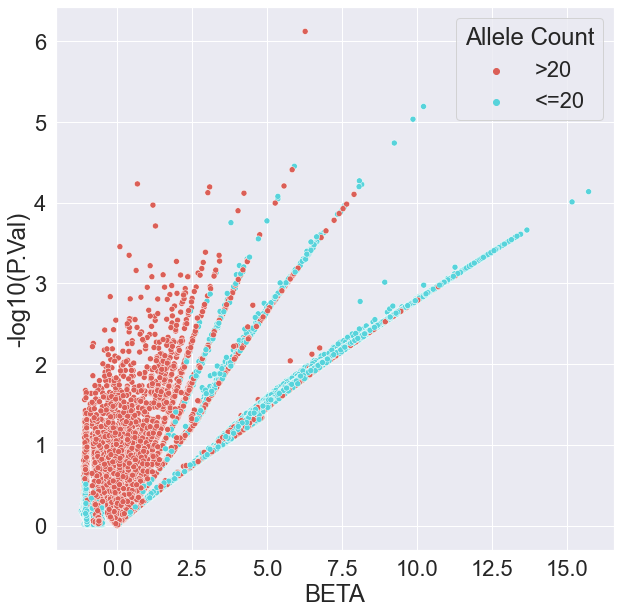

In [1054]:
sns.set_style('whitegrid')
sns.set(font_scale=2)
# take all beta and p-value and make vocano plot
fig  = plt.figure(figsize=(10, 10))


# sns.jointplot(data=VEPwithGB_icd10, x="BETA", y=VEPwithGB_icd10['Pvalue'].apply(lambda x:-np.log10(x)),hue="label")
# custom_palette = sns.color_palette("flare", as_cmap=True)
custom_palette = sns.color_palette("hls", 2)

sns.scatterplot(data=VEPwithGB_icd10, x="BETA", y=VEPwithGB_icd10['Pvalue'].apply(lambda x:-np.log10(x)), hue=VEPwithGB_icd10["AC_label"],palette=custom_palette)
plt.ylabel("-log10(P.Val)")

legend = plt.legend(title="Allele Count",loc='upper right')





plt.show()


# plt.tight_layout()
# plt.savefig('gene68_icd10_vocano.png')


In [970]:
VEPwithGB_icd10.columns

Index(['Location', 'Allele', 'Protein_position', 'SYMBOL', 'Amino_acids',
       'locus', 'SIFT', 'PolyPhen', 'BayesDel_addAF_score',
       'BayesDel_noAF_score', 'CADD_phred', 'ClinPred_score', 'DANN_score',
       'DEOGEN2_score', 'FATHMM_score', 'integrated_fitCons_score',
       'LIST-S2_score', 'LRT_score', 'M-CAP_score', 'MVP_score',
       'MetaLR_score', 'MetaRNN_score', 'MetaSVM_score',
       'MutationAssessor_score', 'PROVEAN_score', 'PrimateAI_score',
       'REVEL_score', 'VEST4_score', 'GERP++_RS', 'SiPhy_29way_logOdds',
       'MutPred_score', 'Unnamed: 0', 'alleles', 'markerID', 'gene',
       'annotation', 'call_stats', 'n_cases', 'n_controls', 'heritability',
       'saige_version', 'inv_normalized', 'trait_type', 'phenocode',
       'pheno_sex', 'coding', 'modifier', 'n_cases_defined',
       'n_cases_both_sexes', 'n_cases_females', 'n_cases_males', 'description',
       'description_more', 'coding_description', 'category', 'AC', 'AF',
       'BETA', 'SE', 'AF.Cases

In [839]:
select_label_list = [
    # 'Breast', 
    # 'Digestive system', 
    # 'Endocrine system',
    # 'Hematopoietic and lymphoid system', 
    # 'Nervous system',
    # 'Other sites', 
    # 'Reproductive system', 
    # 'Respiratory system', 
    # 'Skin',
    # 'Urinary system', 
    # 'after treatment(malignant neoplasm)',
    # 'after treatment(not malignant neoplasms)',
    'malignant neoplasm without specification of site',
    ]
                    

In [840]:
VEPwithGB_select = VEPwithGB_icd10[VEPwithGB_icd10['label'].isin(select_label_list)]


In [773]:
np.unique(VEPwithGB_icd10['protein'])

array(['5ht1a_human', '5ht1b_human', '5ht1d_human', '5ht2a_human',
       '5ht2b_human', '5ht2c_human', '5ht4r_human', '5ht5a_human',
       '5ht6r_human', '5ht7r_human', 'aa1r_human', 'aa2ar_human',
       'aa2br_human', 'aa3r_human', 'acm1_human', 'acm3_human',
       'acm4_human', 'acm5_human', 'ada1a_human', 'ada1b_human',
       'ada1d_human', 'ada2a_human', 'ada2b_human', 'adrb1_human',
       'adrb2_human', 'adrb3_human', 'calrl_human', 'casr_human',
       'ccr1_human', 'ccr2_human', 'ccr3_human', 'ccr5_human',
       'ccr8_human', 'cnr2_human', 'crfr1_human', 'cxcr1_human',
       'cxcr2_human', 'cxcr3_human', 'cxcr4_human', 'drd1_human',
       'drd2_human', 'drd3_human', 'drd4_human', 'drd5_human',
       'ednrb_human', 'fshr_human', 'ghrhr_human', 'gipr_human',
       'glp1r_human', 'glr_human', 'grm1_human', 'grm2_human',
       'grm5_human', 'hrh1_human', 'hrh2_human', 'hrh3_human',
       'hrh4_human', 'lshr_human', 'mc4r_human', 'p2ry2_human',
       'p2y12_human', 'pth

## classification report

In [15]:
# read in the treshold file
sthresh = pd.read_csv('score_threshold.csv')
sthresh

,VEP,threshold,greater than
0,SIFT,0.050000,0
1,PolyPhen,0.500000,1
2,BayesDel_addAF_score,0.069265,1
3,BayesDel_noAF_score,-0.057010,1
4,CADD_phred,20.000000,1
5,ClinPred_score,0.500000,1
6,DANN_score,0.990000,1
7,DEOGEN2_score,0.500000,1
8,FATHMM_score,-1.500000,0
9,integrated_fitCons_score,0.300000,1


In [13]:
# import the names of VEPs
VEP_list = ["SIFT",
"PolyPhen",
"BayesDel_addAF_score",
"BayesDel_noAF_score",
"CADD_phred",
"ClinPred_score",
"DANN_score",
"DEOGEN2_score",
"FATHMM_score",
"integrated_fitCons_score",
"LIST-S2_score",
"LRT_score",
"M-CAP_score",
"MVP_score",
"MetaLR_score",
"MetaRNN_score",
"MetaSVM_score",
"MutationAssessor_score",
"PROVEAN_score",
"PrimateAI_score",
"REVEL_score",
"VEST4_score",
"GERP++_RS",
"SiPhy_29way_logOdds",
"MutPred_score"]

### distriburion of vep scores for two groups

In [847]:
# into 3 classes
# VEPwithGB_icd10['class'] = VEPwithGB_icd10.apply(
#     lambda row: 0 if (row['BETA'] < 1 and row['Pvalue'] > 0.1) else 
#               (2 if (row['BETA'] > 2 and row['Pvalue'] < 0.1) else 1),
#     axis=1
# )


# into 2 classes
# VEPwithGB_icd10['class'] = VEPwithGB_icd10.apply(lambda row: 0 if (row['Pvalue'] > 0.5) else 1, axis=1)


# class_counts = VEPwithGB_icd10['class'].value_counts()
# print(class_counts)


VEPwithGB_select['class'] = VEPwithGB_select.apply(lambda row: 'no/low effect' if (row['BETA'] < 2 and row['Pvalue']>0.1) else 'have effect', axis=1)
# VEPwithGB_select['pca_class'] = VEPwithGB_select.apply(lambda row: 0 if (row['pca1'] < 0) else 1, axis=1)

class_counts = VEPwithGB_select['class'].value_counts()
print(class_counts)

no/low effect    57992
have effect       3668
Name: class, dtype: int64


/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_55020/169058105.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VEPwithGB_select['class'] = VEPwithGB_select.apply(lambda row: 'no/low effect' if (row['BETA'] < 2 and row['Pvalue']>0.1) else 'have effect', axis=1)


Text(336.9714285714286, 0.5, '-log10(P.Val)')

<Figure size 720x720 with 0 Axes>

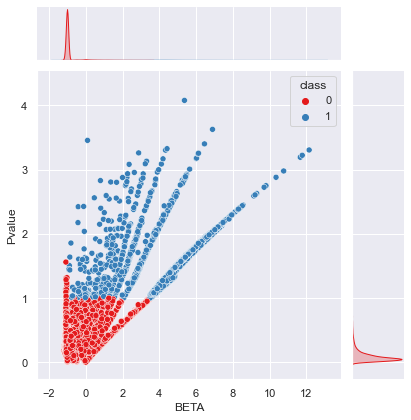

In [844]:
sns.set_style('darkgrid')
# take all beta and p-value and make vocano plot
plt.figure(figsize=(10, 10))
sns.jointplot(data=VEPwithGB_select, x="BETA", y=VEPwithGB_select['Pvalue'].apply(lambda x:-np.log10(x)), hue="class", palette="Set1")
# sns.jointplot(data=VEPwithGB_select, x="BETA", y=VEPwithGB_select['Pvalue'].apply(lambda x:-np.log10(x)), hue="pca_class", palette="Set1")
plt.ylabel("-log10(P.Val)")

In [ ]:
# sns.set_style('white')
# for i in range(len(VEP_list)):
#     vep = sthresh['VEP'][i]
#     temp1 = VEPwithGB_select[VEPwithGB_select[vep]!='-'][['SYMBOL', 'Protein_position','Amino_acids',vep,'BETA','Pvalue','class']].reset_index(drop=True)
#     p1 = re.compile(r'[(](.*?)[)]', re.S)
#     if vep == 'SIFT' or vep == 'PolyPhen':
#         temp1[vep] = temp1[vep].apply(lambda x: float(re.findall(p1,x)[0])) 
#     elif vep == 'DEOGEN2_score' or vep == 'FATHMM_score' or vep == 'LIST-S2_score' or vep == 'MetaRNN_score' or vep == 'MVP_score' or vep == 'MutationAssessor_score' or vep == 'PROVEAN_score' or vep == 'REVEL_score' or vep == 'VEST4_score':
#         temp2 = temp1[vep].apply(lambda x: list(set(str(x).split(',')) - set(['.'])))
#         temp2 = temp2.apply(lambda x: float(x[0]) if len(x) > 0 else None)
#         temp1[vep] = temp2
#         temp1 = temp1.dropna(subset=[vep]).reset_index(drop=True)
#     temp1[vep] = temp1[vep].astype(float)
#     plt.figure(figsize=(10, 10))
#     sns.displot(data=temp1, x=vep,common_norm=False, hue="class",  kind="kde", palette="Set1")
#     plt.savefig(f'cancersubset_distribution_vepscores_2groups/{vep}.png')
#     # ax = sns.boxplot(data=temp1, x=vep, y="class")
#     plt.show()


no/low effect    9533
have effect      5793
Name: class, dtype: int64


<Figure size 720x720 with 0 Axes>

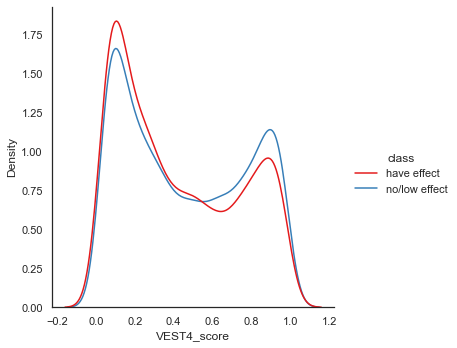

no/low effect    12385
have effect       2941
Name: class, dtype: int64


<Figure size 720x720 with 0 Axes>

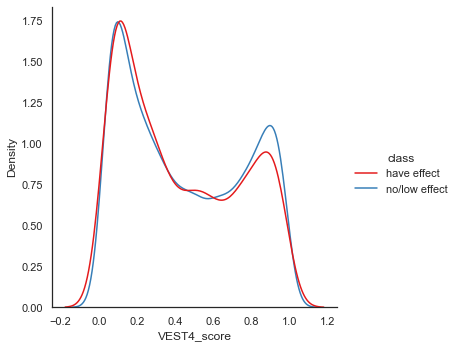

no/low effect    12781
have effect       2545
Name: class, dtype: int64


<Figure size 720x720 with 0 Axes>

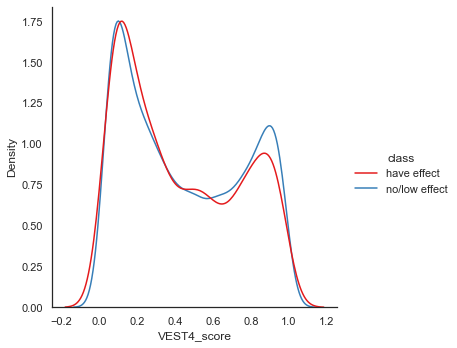

In [900]:
sns.set_style('white')
for beta in [-1,2,5]:
    vep = 'VEST4_score'
    temp1 = VEPwithGB_select[VEPwithGB_select[vep]!='-'][['SYMBOL', 'Protein_position','Amino_acids',vep,'BETA','Pvalue']].reset_index(drop=True)
    # temp1['class'] = temp1.apply(lambda row: 'no/low effect' if (row['BETA'] < beta and row['Pvalue']>0.1) else 'have effect', axis=1)
    temp1['class_bin'] = temp1.apply(lambda row: 0 if (row['BETA'] < beta and row['Pvalue']>0.1) else 1, axis=1)
    # print(temp1['class'].value_counts())
    p1 = re.compile(r'[(](.*?)[)]', re.S)
    if vep == 'SIFT' or vep == 'PolyPhen':
        temp1[vep] = temp1[vep].apply(lambda x: float(re.findall(p1,x)[0])) 
    elif vep == 'DEOGEN2_score' or vep == 'FATHMM_score' or vep == 'LIST-S2_score' or vep == 'MetaRNN_score' or vep == 'MVP_score' or vep == 'MutationAssessor_score' or vep == 'PROVEAN_score' or vep == 'REVEL_score' or vep == 'VEST4_score':
        temp2 = temp1[vep].apply(lambda x: list(set(str(x).split(',')) - set(['.'])))
        temp2 = temp2.apply(lambda x: float(x[0]) if len(x) > 0 else None)
        temp1[vep] = temp2
        temp1 = temp1.dropna(subset=[vep]).reset_index(drop=True)
    temp1[vep] = temp1[vep].astype(float)
    # aggregation == 'max'
    ag_temp = temp1.groupby(by=["SYMBOL","Protein_position","Amino_acids"])[[vep,'class_bin']].max()
    ag_temp['class'] = ag_temp['class_bin'].apply(lambda x: 'have effect' if x ==1  else 'no/low effect')
    print(ag_temp['class'].value_counts())
    my_pal = {"have effect": sns.color_palette("Set1")[0], "no/low effect": sns.color_palette("Set1")[1]}

    plt.figure(figsize=(10, 10))
    # fig, ax = plt.subplots(figsize=(10, 6))
    sns.displot(data=ag_temp, x=vep, common_norm=False, kind="kde", hue="class", palette=my_pal)
    # displaying the title
    # plt.title(f'Foldchange threshold: +/-{fc}')
    # plt.tight_layout()
    # plt.savefig(f'gb_distribution_vepscores_2groups/{vep}_beta{beta}.png')
    # ax = sns.boxplot(data=temp1, x=vep, y="class")
    plt.show()



no/low effect    12600
have effect       2726
Name: class, dtype: int64


<Figure size 720x720 with 0 Axes>

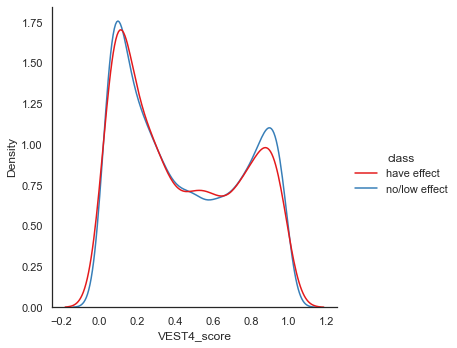

no/low effect    12579
have effect       2747
Name: class, dtype: int64


<Figure size 720x720 with 0 Axes>

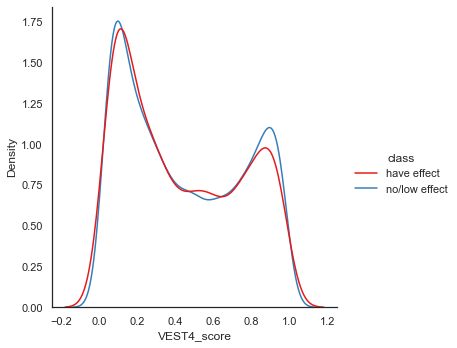

no/low effect    12385
have effect       2941
Name: class, dtype: int64


<Figure size 720x720 with 0 Axes>

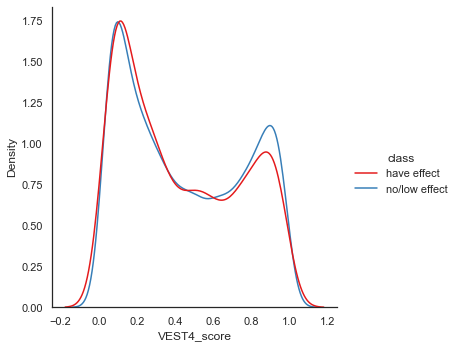

In [902]:
for pval in [0.001,0.01,0.1]:
    vep = 'VEST4_score'
    temp1 = VEPwithGB_select[VEPwithGB_select[vep]!='-'][['SYMBOL', 'Protein_position','Amino_acids',vep,'BETA','Pvalue']].reset_index(drop=True)
    temp1['class_bin'] = temp1.apply(lambda row: 0 if (row['BETA'] < 2 and row['Pvalue']>pval) else 1, axis=1)
    # print(temp1['class'].value_counts())
    p1 = re.compile(r'[(](.*?)[)]', re.S)
    if vep == 'SIFT' or vep == 'PolyPhen':
        temp1[vep] = temp1[vep].apply(lambda x: float(re.findall(p1,x)[0])) 
    elif vep == 'DEOGEN2_score' or vep == 'FATHMM_score' or vep == 'LIST-S2_score' or vep == 'MetaRNN_score' or vep == 'MVP_score' or vep == 'MutationAssessor_score' or vep == 'PROVEAN_score' or vep == 'REVEL_score' or vep == 'VEST4_score':
        temp2 = temp1[vep].apply(lambda x: list(set(str(x).split(',')) - set(['.'])))
        temp2 = temp2.apply(lambda x: float(x[0]) if len(x) > 0 else None)
        temp1[vep] = temp2
        temp1 = temp1.dropna(subset=[vep]).reset_index(drop=True)
    temp1[vep] = temp1[vep].astype(float)
    # aggregation == 'max'
    ag_temp = temp1.groupby(by=["SYMBOL","Protein_position","Amino_acids"])[[vep,'class_bin']].max()
    ag_temp['class'] = ag_temp['class_bin'].apply(lambda x: 'have effect' if x ==1  else 'no/low effect')
    print(ag_temp['class'].value_counts())
    my_pal = {"have effect": sns.color_palette("Set1")[0], "no/low effect": sns.color_palette("Set1")[1]}

    plt.figure(figsize=(10, 10))
    # fig, ax = plt.subplots(figsize=(10, 6))
    sns.displot(data=ag_temp, x=vep, common_norm=False, kind="kde", hue="class", palette=my_pal)
    # displaying the title
    # plt.title(f'Foldchange threshold: +/-{fc}')
    # plt.tight_layout()
    # plt.savefig(f'gb_distribution_vepscores_2groups/{vep}_beta{beta}.png')
    # ax = sns.boxplot(data=temp1, x=vep, y="class")
    plt.show()



### calculate the performance of Ensembl VEPs

In [7]:
def get_performance(VEPwithGB,aggregation,beta,pval,general=True):
    # whether to do aggregation
    aggregation = 'mean'
    # print('start: ',aggregation)
    perf_df = pd.DataFrame()

    row = 0
    for i in range(len(VEP_list)):  
        vep = sthresh['VEP'][i]
        # print('processing VEP: ',vep)
        thresh_value = sthresh['threshold'][i]
        thresh_greather = sthresh['greater than'][i]

        temp1 = VEPwithGB[VEPwithGB[vep]!='-'][['SYMBOL', 'Protein_position','Amino_acids',vep,'BETA','Pvalue']].reset_index(drop=True)
        p1 = re.compile(r'[(](.*?)[)]', re.S)
        if vep == 'SIFT' or vep == 'PolyPhen':
            temp1[vep] = temp1[vep].apply(lambda x: float(re.findall(p1,x)[0])) 
        elif vep == 'DEOGEN2_score' or vep == 'FATHMM_score' or vep == 'LIST-S2_score' or vep == 'MetaRNN_score' or vep == 'MVP_score' or vep == 'MutationAssessor_score' or vep == 'PROVEAN_score' or vep == 'REVEL_score' or vep == 'VEST4_score':
            temp2 = temp1[vep].apply(lambda x: list(set(str(x).split(',')) - set(['.'])))
            temp2 = temp2.apply(lambda x: float(x[0]) if len(x) > 0 else None)
            temp1[vep] = temp2
            temp1 = temp1.dropna(subset=[vep]).reset_index(drop=True)
            
        if temp1.shape[0]==0:
            continue
        else:
            temp1[vep] = temp1[vep].astype(float)
          
        if thresh_greather==1:
            temp1['vep_group'] = temp1[vep].apply(lambda x: 1 if x > thresh_value else 0)
        else:
            temp1['vep_group'] = temp1[vep].apply(lambda x: 1 if x < thresh_value else 0)
        

        # temp1['BETA_group'] = temp1['BETA'].apply(lambda x: 1 if x < -2 else (1 if x > 2 else 0))
        temp1['GB_group'] = temp1.apply(lambda row: 0 if (row['BETA'] < beta and row['Pvalue'] > pval) else 1, axis=1)


        if aggregation == 'mean':
            ag_df = temp1.groupby(by=["SYMBOL","Protein_position","Amino_acids"]).mean()[['vep_group','GB_group']]
            ag_df['ag_GB_group'] = (ag_df['GB_group'] >= 0.3).astype(int)
            exp_labels = ag_df['ag_GB_group']
            pred_labels = ag_df['vep_group'].astype(int)
        
        elif aggregation == 'max':
            ag_df = temp1.groupby(by=["SYMBOL","Protein_position","Amino_acids"]).max()[['vep_group','GB_group']]
            exp_labels = ag_df['GB_group']
            pred_labels = ag_df['vep_group']   

        else:
            exp_labels = temp1['GB_group']
            pred_labels = temp1['vep_group']
            
        
        # Calculate accuracy
        accuracy = accuracy_score(exp_labels, pred_labels)
        # Calculate precision, recall and F1-score
        precision = precision_score(exp_labels, pred_labels)
        recall = recall_score(exp_labels, pred_labels)
        f1 = f1_score(exp_labels, pred_labels)

        # calculate Matthews Correlation Coefficient
        mcc = matthews_corrcoef(exp_labels, pred_labels)


        # store in df
        perf_df.loc[row,'vep'] = vep
        perf_df.loc[row,'accuracy'] = accuracy
        perf_df.loc[row,'precision'] = precision
        perf_df.loc[row,'f1-score'] = f1
        perf_df.loc[row,'mcc'] = mcc
        
        if general:
            # calculate FPR and TPR
            fpr, tpr, thresholds = roc_curve(exp_labels, pred_labels)
            # calculate AUCROC
            auc_roc = auc(fpr, tpr)
            # Calculate confusion matrix
            tn, fp, fn, tp = confusion_matrix(exp_labels, pred_labels).ravel()

            # Calculate specificity and sensitivity
            specificity = tn / (tn + fp)
            sensitivity = tp / (tp + fn)
            perf_df.loc[row,'specificity'] = specificity
            perf_df.loc[row,'sensitivity'] = sensitivity
            perf_df.loc[row,'AUC'] = auc_roc
            perf_df.loc[row,'#tp/#fp'] = str(tp)+'/'+str(fp)
            perf_df.loc[row,'#tn/#fn'] = str(tn)+'/'+str(fn)
            perf_df.loc[row,'#exp_negative'] = str(exp_labels.value_counts()[[0,1]][0])
            perf_df.loc[row,'#exp_positive'] = str(exp_labels.value_counts()[[0,1]][1])
            perf_df.loc[row,'#pred_negative'] = str(pred_labels.value_counts()[[0,1]][0])
            perf_df.loc[row,'#pred_positive'] = str(pred_labels.value_counts()[[0,1]][1])
        row = row +1
    return perf_df


In [462]:
# perf_df_noAG = get_performance(VEPwithGB_icd10,None)
perf_df_AG_max = get_performance(VEPwithGB_icd10,'max')
perf_df_AG_max
# perf_df_AG_mean = get_performance(VEPwithGB_icd10, 'mean')

,vep,accuracy,specificity,sensitivity,precision,f1-score,mcc,AUC,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive
0,SIFT,0.468530,0.438406,0.513916,0.377870,0.435516,-0.046864,0.476161,3176/5229,4082/3004,9311,6180,7086,8405
1,PolyPhen,0.492931,0.530770,0.435922,0.381424,0.406856,-0.032748,0.483346,2694/4369,4942/3486,9311,6180,8428,7063
2,BayesDel_addAF_score,0.501840,0.651380,0.276465,0.344772,0.306863,-0.075752,0.463922,1708/3246,6065/4470,9311,6178,10535,4954
3,BayesDel_noAF_score,0.521531,0.696918,0.257203,0.360236,0.300123,-0.049778,0.477060,1589/2822,6489/4589,9311,6178,11078,4411
4,CADD_phred,0.443161,0.324240,0.622330,0.379365,0.471381,-0.055017,0.473285,3846/6292,3019/2334,9311,6180,5353,10138
5,ClinPred_score,0.424366,0.361508,0.519100,0.350415,0.418395,-0.118904,0.440304,3207/5945,3366/2971,9311,6178,6337,9152
6,DANN_score,0.484602,0.462679,0.517643,0.389952,0.444815,-0.019305,0.490161,3198/5003,4308/2980,9311,6178,7288,8201
7,DEOGEN2_score,0.542317,0.759580,0.215844,0.374007,0.273721,-0.028577,0.487712,1177/1970,6224/4276,8194,5453,10500,3147
8,FATHMM_score,0.563562,0.808049,0.194133,0.400953,0.261603,0.002708,0.501091,1178/1760,7409/4890,9169,6068,12299,2938
9,integrated_fitCons_score,0.399687,0.001305,0.998692,0.399425,0.570628,-0.000042,0.499998,6108/9184,12/8,9196,6116,20,15292


In [202]:
# perf_df_noAG.to_csv('perf_GB_NoAgg.csv',index=False)
# perf_df_AG_max.to_csv('perf_GB_Agg_max.csv',index=False)
# perf_df_AG_mean.to_csv('perf_GB_Agg_mean30.csv',index=False)


## other VEP outside Ensembl VEP

In [8]:
def get_performance_other(vep_gb_df,vep,aggregation,beta,pval,general=True):
    
    if vep == 'VESPAl':
        # VESPAl into two classifications: >=0.5(positive) <0.5(negative)
        vep_gb_df['vep_group'] = vep_gb_df[vep].apply(lambda x: 1 if x > 0.5 else 0)
    elif vep == 'Dynamut2':
         # ddg into two classifications: <0: Destabilising, >0: stabilising
        vep_gb_df['vep_group'] = vep_gb_df[vep].apply(lambda x: 1 if x < 0 else 0) 
    elif  vep == 'FoldX':
         # ddg into two classifications: <0: Destabilising, >0: stabilising
        vep_gb_df['vep_group'] = vep_gb_df[vep].apply(lambda x: 1 if x < 1.5 else 0)     
    elif  vep == 'RaSP':
         # ddg into two classifications: <0: Destabilising, >0: stabilising
        vep_gb_df['vep_group'] = vep_gb_df[vep].apply(lambda x: 1 if x < 2.5 else 0)    

    # vep_gb_df['BETA_group'] = vep_gb_df['BETA'].apply(lambda x: 1 if x < -2 else (1 if x > 2 else 0))
    vep_gb_df['GB_group'] = vep_gb_df.apply(lambda row: 0 if (row['BETA'] < beta and row['Pvalue'] > pval) else 1, axis=1)

    # aggregation = 'mean'

    if aggregation == 'mean':
        ag_df = vep_gb_df.groupby(by=["SYMBOL","Protein_position","Amino_acids"]).mean()[['vep_group','GB_group']]
        ag_df['ag_beta_group'] = (ag_df['GB_group'] >= 0.3).astype(int)
        exp_labels = ag_df['ag_beta_group']
        pred_labels = ag_df['vep_group'].astype(int)
    
    elif aggregation == 'max':
        ag_df = vep_gb_df.groupby(by=["SYMBOL","Protein_position","Amino_acids"]).max()[['vep_group','GB_group']]
        exp_labels = ag_df['GB_group']
        pred_labels = ag_df['vep_group']   

    else:
        exp_labels = vep_gb_df['GB_group']
        pred_labels = vep_gb_df['vep_group']
    row = 0
    perf_df = pd.DataFrame()
    # Calculate accuracy
    accuracy = accuracy_score(exp_labels, pred_labels)
    # Calculate precision, recall and F1-score
    precision = precision_score(exp_labels, pred_labels)
    recall = recall_score(exp_labels, pred_labels)
    f1 = f1_score(exp_labels, pred_labels)
    # calculate Matthews Correlation Coefficient
    mcc = matthews_corrcoef(exp_labels, pred_labels)


    # store in df
    perf_df.loc[row,'vep'] = vep
    perf_df.loc[row,'accuracy'] = accuracy
    perf_df.loc[row,'precision'] = precision
    perf_df.loc[row,'f1-score'] = f1
    perf_df.loc[row,'mcc'] = mcc

    if general:
        # calculate FPR and TPR
        fpr, tpr, thresholds = roc_curve(exp_labels, pred_labels)

        # calculate AUCROC
        auc_roc = auc(fpr, tpr)
        perf_df.loc[row,'AUC'] = auc_roc
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(exp_labels, pred_labels).ravel()
        # Calculate specificity and sensitivity
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        perf_df.loc[row,'specificity'] = specificity
        perf_df.loc[row,'sensitivity'] = sensitivity
        perf_df.loc[row,'#tp/#fp'] = str(tp)+'/'+str(fp)
        perf_df.loc[row,'#tn/#fn'] = str(tn)+'/'+str(fn)
        perf_df.loc[row,'#exp_negative'] = str(exp_labels.value_counts()[[0,1]][0])
        perf_df.loc[row,'#exp_positive'] = str(exp_labels.value_counts()[[0,1]][1])
        perf_df.loc[row,'#pred_negative'] = str(pred_labels.value_counts()[[0,1]][0])
        perf_df.loc[row,'#pred_positive'] = str(pred_labels.value_counts()[[0,1]][1])
    return perf_df


In [615]:
gb_with_dyna = pd.read_csv('Genebass_with_Dynamut2_df.csv')
gb_with_dyna

/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (20,21,22,23,24,25,26,28,30,31,32,33,34,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,mutation_from,Protein_position,mutation_to,mutation,chain,Dynamut2,Uniprot,protein,SYMBOL,Location,...,coding_description,category,AC,AF,BETA,SE,AF.Cases,AF.Controls,Pvalue,vcf
0,Q,231,R,Q231R,A,-0.49,P07550,adrb2_human,ADRB2,5:148827523-148827523,...,NaN,Chapter II Neoplasms | C15-C26 Malignant neopl...,1,0.000001,-1.0004,57.3580,0.0,0.000001,0.98608,5 148827523 . A G
1,Q,231,R,Q231R,A,-0.49,P07550,adrb2_human,ADRB2,5:148827523-148827523,...,NaN,Chapter II Neoplasms | C15-C26 Malignant neopl...,1,0.000001,-1.0003,58.7630,0.0,0.000001,0.98642,5 148827523 . A G
2,Q,231,R,Q231R,A,-0.49,P07550,adrb2_human,ADRB2,5:148827523-148827523,...,NaN,Chapter II Neoplasms | C15-C26 Malignant neopl...,1,0.000001,-1.0002,102.7300,0.0,0.000001,0.99223,5 148827523 . A G
3,Q,231,R,Q231R,A,-0.49,P07550,adrb2_human,ADRB2,5:148827523-148827523,...,NaN,Chapter II Neoplasms | C15-C26 Malignant neopl...,1,0.000001,-1.0032,19.1680,0.0,0.000001,0.95826,5 148827523 . A G
4,Q,231,R,Q231R,A,-0.49,P07550,adrb2_human,ADRB2,5:148827523-148827523,...,NaN,Chapter II Neoplasms | C15-C26 Malignant neopl...,1,0.000001,-1.0008,38.3230,0.0,0.000001,0.97916,5 148827523 . A G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654418,H,387,Y,H387Y,A,1.17,Q9Y5N1,hrh3_human,HRH3,20:62216185-62216185,...,NaN,Chapter XXI Factors influencing health status ...,3,0.000004,-1.0365,4.1876,0.0,0.000004,0.80451,20 62216185 . G A
654419,H,387,Y,H387Y,A,1.17,Q9Y5N1,hrh3_human,HRH3,20:62216185-62216185,...,NaN,Chapter XXI Factors influencing health status ...,3,0.000004,-1.0365,3.4088,0.0,0.000004,0.76108,20 62216185 . G A
654420,H,387,Y,H387Y,A,1.17,Q9Y5N1,hrh3_human,HRH3,20:62216185-62216185,...,NaN,Chapter XXI Factors influencing health status ...,3,0.000004,-1.0163,4.7195,0.0,0.000004,0.82950,20 62216185 . G A
654421,H,387,Y,H387Y,A,1.17,Q9Y5N1,hrh3_human,HRH3,20:62216185-62216185,...,NaN,Chapter XXI Factors influencing health status ...,3,0.000004,-1.0252,3.9932,0.0,0.000004,0.79739,20 62216185 . G A


In [465]:
dyna_res = get_performance_other(gb_with_dyna,'Dynamut2','max')
dyna_res

/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_55020/2046596221.py:24: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  ag_df = vep_gb_df.groupby(by=["SYMBOL","Protein_position","Amino_acids"]).max()[['vep_group','GB_group']]


,vep,accuracy,specificity,sensitivity,precision,f1-score,mcc,AUC,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive
0,Dynamut2,0.462929,0.227826,0.771079,0.432421,0.554102,-0.001292,0.499453,5167/6782,2001/1534,8783,6701,3535,11949


In [251]:
gb_with_vespa = pd.read_csv('Genebass_with_VESPAl_df.csv')
gb_with_vespa

/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Location,Allele,Protein_position,SYMBOL,Amino_acids,loc_m,SIFT,PolyPhen,BayesDel_addAF_score,BayesDel_noAF_score,...,BETA,SE,AF.Cases,AF.Controls,Pvalue,vcf,mutation_from,mutation_to,Uniprot_ID,VESPAl
0,11:113416935-113416935,T,154,DRD2,V/I,113416935,tolerated(0.15),possibly_damaging(0.656),0.134914,0.141922,...,-1.00480,6.3053,0.000000,0.000015,0.873390,11 113416935 . C T,V,I,P14416,0.118742
1,11:113416935-113416935,T,154,DRD2,V/I,113416935,tolerated(0.15),possibly_damaging(0.656),0.134914,0.141922,...,-1.00340,7.2464,0.000000,0.000015,0.889870,11 113416935 . C T,V,I,P14416,0.118742
2,11:113416935-113416935,T,154,DRD2,V/I,113416935,tolerated(0.15),possibly_damaging(0.656),0.134914,0.141922,...,-0.99774,13.0160,0.000000,0.000015,0.938900,11 113416935 . C T,V,I,P14416,0.118742
3,11:113416935-113416935,T,154,DRD2,V/I,113416935,tolerated(0.15),possibly_damaging(0.656),0.134914,0.141922,...,-1.01020,3.2737,0.000000,0.000015,0.757640,11 113416935 . C T,V,I,P14416,0.118742
4,11:113416935-113416935,T,154,DRD2,V/I,113416935,tolerated(0.15),possibly_damaging(0.656),0.134914,0.141922,...,-1.00350,6.4900,0.000000,0.000015,0.877120,11 113416935 . C T,V,I,P14416,0.118742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555366,X:114907411-114907411,C,458,HTR2C,V/A,114907411,deleterious(0),benign(0.309),-0.00911951,-0.250876,...,-1.00770,7.8299,0.000000,0.000004,0.897600,X 114907411 . T C,V,A,P28335,0.463933
555367,X:114907411-114907411,C,458,HTR2C,V/A,114907411,deleterious(0),benign(0.309),-0.00911951,-0.250876,...,5.12980,2.3304,0.000049,0.000003,0.027721,X 114907411 . T C,V,A,P28335,0.463933
555368,X:114907411-114907411,C,458,HTR2C,V/A,114907411,deleterious(0),benign(0.309),-0.00911951,-0.250876,...,-1.01590,4.9158,0.000000,0.000004,0.836280,X 114907411 . T C,V,A,P28335,0.463933
555369,X:114907411-114907411,C,458,HTR2C,V/A,114907411,deleterious(0),benign(0.309),-0.00911951,-0.250876,...,-1.02280,3.1895,0.000000,0.000004,0.748460,X 114907411 . T C,V,A,P28335,0.463933


In [466]:
vespa_res = get_performance_other(gb_with_vespa,'VESPAl','max')
vespa_res

/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_55020/2046596221.py:24: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  ag_df = vep_gb_df.groupby(by=["SYMBOL","Protein_position","Amino_acids"]).max()[['vep_group','GB_group']]


,vep,accuracy,specificity,sensitivity,precision,f1-score,mcc,AUC,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive
0,VESPAl,0.525162,0.78354,0.189284,0.402158,0.257412,-0.033393,0.486412,1081/1607,5817/4630,7424,5711,10447,2688


In [597]:
gb_with_fx = pd.read_csv('Genebass_with_FoldX_df.csv')
gb_with_fx

/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13,14,15,16,17,18,19,21,23,24,25,26,27,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Location,Allele,Protein_position,SYMBOL,Amino_acids,locus,SIFT,PolyPhen,BayesDel_addAF_score,BayesDel_noAF_score,...,AF.Cases,AF.Controls,Pvalue,vcf,mutation_from,mutation_to,Uniprot,FoldX,mutation data,protein
0,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,0.003472,0.002413,0.421890,11 113412715 . T C,K,E,P14416,-0.466725,KA327E,drd2_human
1,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,0.001845,0.002416,0.688580,11 113412715 . T C,K,E,P14416,-0.466725,KA327E,drd2_human
2,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,0.005556,0.002413,0.223580,11 113412715 . T C,K,E,P14416,-0.466725,KA327E,drd2_human
3,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,0.002068,0.002417,0.602020,11 113412715 . T C,K,E,P14416,-0.466725,KA327E,drd2_human
4,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,0.002584,0.002415,0.890100,11 113412715 . T C,K,E,P14416,-0.466725,KA327E,drd2_human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654418,X:114907411-114907411,C,458,HTR2C,V/A,chrX:114907411,deleterious(0),benign(0.309),-0.009120,-0.250876,...,0.000000,0.000004,0.897600,X 114907411 . T C,V,A,P28335,0.020199,VA458A,5ht2c_human
654419,X:114907411-114907411,C,458,HTR2C,V/A,chrX:114907411,deleterious(0),benign(0.309),-0.009120,-0.250876,...,0.000049,0.000003,0.027721,X 114907411 . T C,V,A,P28335,0.020199,VA458A,5ht2c_human
654420,X:114907411-114907411,C,458,HTR2C,V/A,chrX:114907411,deleterious(0),benign(0.309),-0.009120,-0.250876,...,0.000000,0.000004,0.836280,X 114907411 . T C,V,A,P28335,0.020199,VA458A,5ht2c_human
654421,X:114907411-114907411,C,458,HTR2C,V/A,chrX:114907411,deleterious(0),benign(0.309),-0.009120,-0.250876,...,0.000000,0.000004,0.748460,X 114907411 . T C,V,A,P28335,0.020199,VA458A,5ht2c_human


In [467]:
foldx_res = get_performance_other(gb_with_fx,'FoldX','max')
foldx_res

/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_55020/2046596221.py:24: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  ag_df = vep_gb_df.groupby(by=["SYMBOL","Protein_position","Amino_acids"]).max()[['vep_group','GB_group']]


,vep,accuracy,specificity,sensitivity,precision,f1-score,mcc,AUC,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive
0,FoldX,0.476621,0.231128,0.798388,0.442039,0.569028,0.035399,0.514758,5350/6753,2030/1351,8783,6701,3381,12103


In [816]:
gb_with_rasp = pd.read_csv('Genebass_with_RaSP_df.csv')
gb_with_rasp

/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13,14,15,16,17,18,19,21,23,24,25,26,27,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Location,Allele,Protein_position,SYMBOL,Amino_acids,locus,SIFT,PolyPhen,BayesDel_addAF_score,BayesDel_noAF_score,...,variant,wt_nlf,mt_nlf,score_ml_fermi,RaSP,b_factors,index,ENST,ENSG,protein
0,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,K327E,2.828313,2.712832,0.281960,0.663100,35.73,24481,ENST00000362072,ENSG00000149295,drd2_human
1,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,K327E,2.828313,2.712832,0.281960,0.663100,35.73,24481,ENST00000362072,ENSG00000149295,drd2_human
2,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,K327E,2.828313,2.712832,0.281960,0.663100,35.73,24481,ENST00000362072,ENSG00000149295,drd2_human
3,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,K327E,2.828313,2.712832,0.281960,0.663100,35.73,24481,ENST00000362072,ENSG00000149295,drd2_human
4,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,K327E,2.828313,2.712832,0.281960,0.663100,35.73,24481,ENST00000362072,ENSG00000149295,drd2_human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654418,X:114907411-114907411,C,458,HTR2C,V/A,chrX:114907411,deleterious(0),benign(0.309),-0.009120,-0.250876,...,V458A,2.623741,2.483982,0.214082,-0.251229,43.06,54940,ENST00000276198,ENSG00000147246,5ht2c_human
654419,X:114907411-114907411,C,458,HTR2C,V/A,chrX:114907411,deleterious(0),benign(0.309),-0.009120,-0.250876,...,V458A,2.623741,2.483982,0.214082,-0.251229,43.06,54940,ENST00000276198,ENSG00000147246,5ht2c_human
654420,X:114907411-114907411,C,458,HTR2C,V/A,chrX:114907411,deleterious(0),benign(0.309),-0.009120,-0.250876,...,V458A,2.623741,2.483982,0.214082,-0.251229,43.06,54940,ENST00000276198,ENSG00000147246,5ht2c_human
654421,X:114907411-114907411,C,458,HTR2C,V/A,chrX:114907411,deleterious(0),benign(0.309),-0.009120,-0.250876,...,V458A,2.623741,2.483982,0.214082,-0.251229,43.06,54940,ENST00000276198,ENSG00000147246,5ht2c_human


In [777]:
rasp_res = get_performance_other(gb_with_rasp,'RaSP','max')
rasp_res

/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_55020/448511505.py:28: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  ag_df = vep_gb_df.groupby(by=["SYMBOL","Protein_position","Amino_acids"]).max()[['vep_group','GB_group']]


,vep,accuracy,precision,f1-score,mcc,AUC,specificity,sensitivity,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive
0,RaSP,0.453371,0.43722,0.591939,0.028018,0.50822,0.100307,0.916132,6139/7902,881/562,8783,6701,1443,14041


In [779]:
perf_df = pd.concat([perf_df_AG_max,dyna_res,vespa_res,foldx_res,rasp_res]).reset_index()
perf_df = perf_df.drop(columns=['index'])
perf_df

,vep,accuracy,specificity,sensitivity,precision,f1-score,mcc,AUC,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive
0,SIFT,0.468530,0.438406,0.513916,0.377870,0.435516,-0.046864,0.476161,3176/5229,4082/3004,9311,6180,7086,8405
1,PolyPhen,0.492931,0.530770,0.435922,0.381424,0.406856,-0.032748,0.483346,2694/4369,4942/3486,9311,6180,8428,7063
2,BayesDel_addAF_score,0.501840,0.651380,0.276465,0.344772,0.306863,-0.075752,0.463922,1708/3246,6065/4470,9311,6178,10535,4954
3,BayesDel_noAF_score,0.521531,0.696918,0.257203,0.360236,0.300123,-0.049778,0.477060,1589/2822,6489/4589,9311,6178,11078,4411
4,CADD_phred,0.443161,0.324240,0.622330,0.379365,0.471381,-0.055017,0.473285,3846/6292,3019/2334,9311,6180,5353,10138
5,ClinPred_score,0.424366,0.361508,0.519100,0.350415,0.418395,-0.118904,0.440304,3207/5945,3366/2971,9311,6178,6337,9152
6,DANN_score,0.484602,0.462679,0.517643,0.389952,0.444815,-0.019305,0.490161,3198/5003,4308/2980,9311,6178,7288,8201
7,DEOGEN2_score,0.542317,0.759580,0.215844,0.374007,0.273721,-0.028577,0.487712,1177/1970,6224/4276,8194,5453,10500,3147
8,FATHMM_score,0.563562,0.808049,0.194133,0.400953,0.261603,0.002708,0.501091,1178/1760,7409/4890,9169,6068,12299,2938
9,integrated_fitCons_score,0.399687,0.001305,0.998692,0.399425,0.570628,-0.000042,0.499998,6108/9184,12/8,9196,6116,20,15292


In [885]:
vep_class = ['single-study deleterious score','single-study deleterious score','meta deleterious score','meta deleterious score','meta deleterious score','meta deleterious score',
             'meta deleterious score','meta deleterious score','single-study deleterious score','conservation score','single-study deleterious score',
             'single-study deleterious score','meta deleterious score','meta deleterious score','meta deleterious score','meta deleterious score','meta deleterious score',
             'single-study deleterious score','single-study deleterious score','single-study deleterious score','meta deleterious score',
             'single-study deleterious score','conservation score','conservation score',
             'single-study deleterious score','ddG prediction','single-study deleterious score','ddG prediction','ddG prediction']
perf_df['vep_class'] = vep_class
perf_df

,vep,accuracy,specificity,sensitivity,precision,f1-score,mcc,AUC,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive,vep_class
SIFT,SIFT,0.468530,0.438406,0.513916,0.377870,0.435516,-0.046864,0.476161,3176/5229,4082/3004,9311,6180,7086,8405,single-study deleterious score
PolyPhen,PolyPhen,0.492931,0.530770,0.435922,0.381424,0.406856,-0.032748,0.483346,2694/4369,4942/3486,9311,6180,8428,7063,single-study deleterious score
BayesDel_addAF_score,BayesDel_addAF_score,0.501840,0.651380,0.276465,0.344772,0.306863,-0.075752,0.463922,1708/3246,6065/4470,9311,6178,10535,4954,meta deleterious score
BayesDel_noAF_score,BayesDel_noAF_score,0.521531,0.696918,0.257203,0.360236,0.300123,-0.049778,0.477060,1589/2822,6489/4589,9311,6178,11078,4411,meta deleterious score
CADD_phred,CADD_phred,0.443161,0.324240,0.622330,0.379365,0.471381,-0.055017,0.473285,3846/6292,3019/2334,9311,6180,5353,10138,meta deleterious score
ClinPred_score,ClinPred_score,0.424366,0.361508,0.519100,0.350415,0.418395,-0.118904,0.440304,3207/5945,3366/2971,9311,6178,6337,9152,meta deleterious score
DANN_score,DANN_score,0.484602,0.462679,0.517643,0.389952,0.444815,-0.019305,0.490161,3198/5003,4308/2980,9311,6178,7288,8201,meta deleterious score
DEOGEN2_score,DEOGEN2_score,0.542317,0.759580,0.215844,0.374007,0.273721,-0.028577,0.487712,1177/1970,6224/4276,8194,5453,10500,3147,meta deleterious score
FATHMM_score,FATHMM_score,0.563562,0.808049,0.194133,0.400953,0.261603,0.002708,0.501091,1178/1760,7409/4890,9169,6068,12299,2938,single-study deleterious score
integrated_fitCons_score,integrated_fitCons_score,0.399687,0.001305,0.998692,0.399425,0.570628,-0.000042,0.499998,6108/9184,12/8,9196,6116,20,15292,conservation score


In [3]:
# perf_df.to_csv('Genebass_VEPs_performance_table_0506.csv',index=False)
perf_df = pd.read_csv("Genebass_VEPs_performance_table_0506.csv")
perf_df

,vep,accuracy,specificity,sensitivity,precision,f1-score,mcc,AUC,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive
0,SIFT,0.468530,0.438406,0.513916,0.377870,0.435516,-0.046864,0.476161,3176/5229,4082/3004,9311,6180,7086,8405
1,PolyPhen,0.492931,0.530770,0.435922,0.381424,0.406856,-0.032748,0.483346,2694/4369,4942/3486,9311,6180,8428,7063
2,BayesDel_addAF_score,0.501840,0.651380,0.276465,0.344772,0.306863,-0.075752,0.463922,1708/3246,6065/4470,9311,6178,10535,4954
3,BayesDel_noAF_score,0.521531,0.696918,0.257203,0.360236,0.300123,-0.049778,0.477060,1589/2822,6489/4589,9311,6178,11078,4411
4,CADD_phred,0.443161,0.324240,0.622330,0.379365,0.471381,-0.055017,0.473285,3846/6292,3019/2334,9311,6180,5353,10138
5,ClinPred_score,0.424366,0.361508,0.519100,0.350415,0.418395,-0.118904,0.440304,3207/5945,3366/2971,9311,6178,6337,9152
6,DANN_score,0.484602,0.462679,0.517643,0.389952,0.444815,-0.019305,0.490161,3198/5003,4308/2980,9311,6178,7288,8201
7,DEOGEN2_score,0.542317,0.759580,0.215844,0.374007,0.273721,-0.028577,0.487712,1177/1970,6224/4276,8194,5453,10500,3147
8,FATHMM_score,0.563562,0.808049,0.194133,0.400953,0.261603,0.002708,0.501091,1178/1760,7409/4890,9169,6068,12299,2938
9,integrated_fitCons_score,0.399687,0.001305,0.998692,0.399425,0.570628,-0.000042,0.499998,6108/9184,12/8,9196,6116,20,15292


In [884]:
from matplotlib.patches import Patch

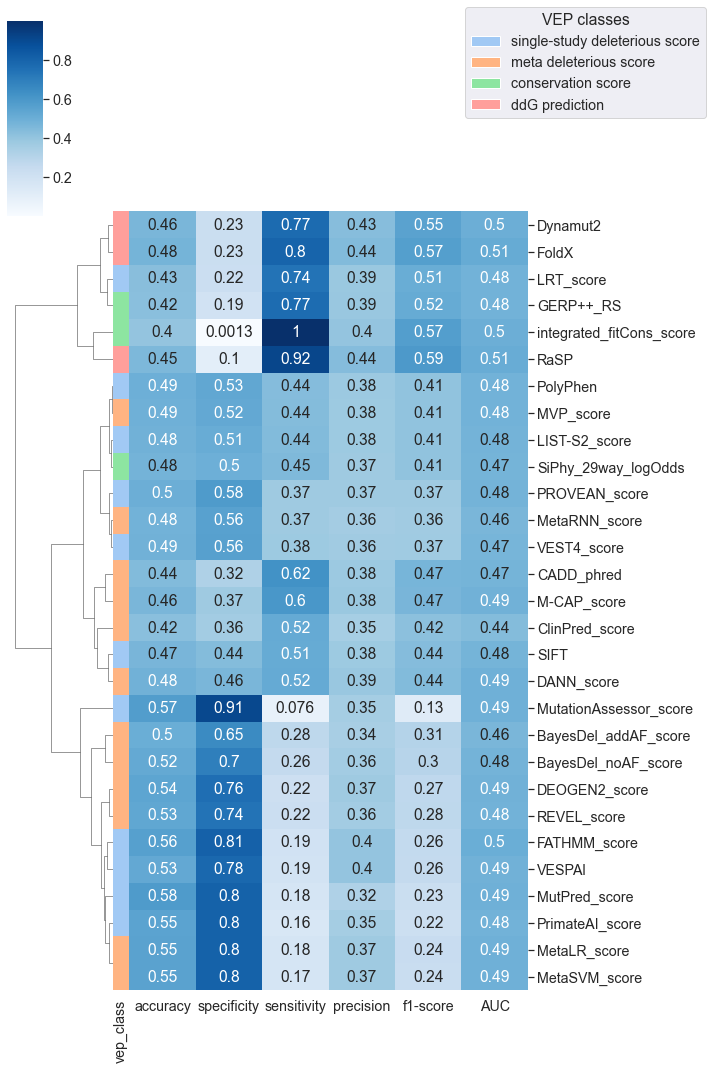

In [1056]:
sns.set(font_scale=1.3)
perf_df = perf_df.rename(index = perf_df['vep'])
# plt.figure(figsize=(8, 10))
lut = dict(zip(perf_df['vep_class'].unique(), sns.color_palette("pastel",4)))
handles = [Patch(facecolor=lut[name]) for name in lut]
row_colors = perf_df['vep_class'].map(lut)
sns.clustermap(perf_df.iloc[:,[1,2,3,4,5,7]], figsize=(10, 15),cmap="Blues",annot=True, col_cluster=False,row_colors=row_colors)
plt.legend(handles, lut, title='VEP classes',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
# ,cbar_kws={'label': 'metrics'}
# plt.savefig('Genebass_clustermap_0512.png',bbox_inches='tight')


## compare performance between subsets

In [18]:
# import the names of VEPs
VEP_list_sub = [
# "SIFT",
"PolyPhen",
# "BayesDel_addAF_score",
# "BayesDel_noAF_score",
"CADD_phred",
# "ClinPred_score",
"DANN_score",
# "DEOGEN2_score",
"FATHMM_score",
# "integrated_fitCons_score",
# "LIST-S2_score",
# "LRT_score",
# "M-CAP_score",
# "MVP_score",
# "MetaLR_score",
# "MetaRNN_score",
# "MetaSVM_score",
# "MutationAssessor_score",
# "PROVEAN_score",
# "PrimateAI_score",
# "REVEL_score",
# "VEST4_score",
"GERP++_RS",
# "SiPhy_29way_logOdds",
"MutPred_score"
]



In [791]:
VEPwithGB_icd10

,Location,Allele,Protein_position,SYMBOL,Amino_acids,locus,SIFT,PolyPhen,BayesDel_addAF_score,BayesDel_noAF_score,...,AF.Cases,AF.Controls,Pvalue,vcf,label,class,protein,pca1,pca2,pca_class
0,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,0.003472,0.002413,0.421890,11 113412715 . T C,Digestive system,0,drd2_human,2.538567,-0.813217,1
1,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,0.001845,0.002416,0.688580,11 113412715 . T C,Digestive system,0,drd2_human,1.059711,-0.277949,0
2,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,0.005556,0.002413,0.223580,11 113412715 . T C,Digestive system,0,drd2_human,3.895759,-0.953722,1
3,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,0.002068,0.002417,0.602020,11 113412715 . T C,Digestive system,0,drd2_human,1.459851,-0.531537,0
4,11:113412715-113412715,C,327,DRD2,K/E,chr11:113412715,tolerated(0.27),benign(0.031),-0.260005,-0.140988,...,0.002584,0.002415,0.890100,11 113412715 . T C,Digestive system,0,drd2_human,0.520562,0.704841,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654733,X:114907411-114907411,C,458,HTR2C,V/A,chrX:114907411,deleterious(0),benign(0.309),-0.00911951,-0.250876,...,0.000000,0.000004,0.897600,X 114907411 . T C,after treatment(malignant neoplasm),0,5ht2c_human,-0.258749,-0.017827,0
654734,X:114907411-114907411,C,458,HTR2C,V/A,chrX:114907411,deleterious(0),benign(0.309),-0.00911951,-0.250876,...,0.000049,0.000003,0.027721,X 114907411 . T C,after treatment(not malignant neoplasms),1,5ht2c_human,7.295387,0.966719,1
654735,X:114907411-114907411,C,458,HTR2C,V/A,chrX:114907411,deleterious(0),benign(0.309),-0.00911951,-0.250876,...,0.000000,0.000004,0.836280,X 114907411 . T C,malignant neoplasm without specification of site,0,5ht2c_human,-0.032899,-0.255085,0
654736,X:114907411-114907411,C,458,HTR2C,V/A,chrX:114907411,deleterious(0),benign(0.309),-0.00911951,-0.250876,...,0.000000,0.000004,0.748460,X 114907411 . T C,malignant neoplasm without specification of site,0,5ht2c_human,0.293923,-0.591506,0


In [10]:
label_list = np.unique(VEPwithGB_icd10["label"])
label_list

array(['Brain', 'Breast', 'Digestive system', 'Endocrine system',
       'Hematopoietic and lymphoid system', 'Other sites',
       'Reproductive system', 'Respiratory system', 'Skin',
       'Urinary system', 'after treatment(malignant neoplasm)',
       'after treatment(not malignant neoplasms)',
       'malignant neoplasm without specification of site'], dtype=object)

In [6]:
gb_with_dyna = pd.read_csv('Genebass_with_Dynamut2_df.csv')
gb_with_vespa = pd.read_csv('Genebass_with_VESPAl_df.csv')
gb_with_fx = pd.read_csv('Genebass_with_FoldX_df.csv')
gb_with_rasp = pd.read_csv('Genebass_with_RaSP_df.csv')



gb_with_dyna["label"] = gb_with_dyna["description"].apply(get_label)
gb_with_vespa["label"] = gb_with_vespa["description"].apply(get_label)
gb_with_fx["label"] = gb_with_fx["description"].apply(get_label)
gb_with_rasp["label"] = gb_with_rasp["description"].apply(get_label)

/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (20,21,22,23,24,25,26,28,30,31,32,33,34,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13,14,15,16,17,18,19,21,23,24,25,26,27,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [909]:
perf_df_dyna

,vep,accuracy,precision,f1-score,mcc,AUC,specificity,sensitivity,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive
0,Dynamut2,0.331027,0.190831,0.305691,-0.004471,0.497617,0.227365,0.767869,2256/9566,2815/682,12381,2938,3497,11822


In [23]:
f1_df = pd.DataFrame()
auc_df = pd.DataFrame()
acc_df = pd.DataFrame()
row = 0
for label in label_list:
    # Ensembl VEP
    subset_icd = VEPwithGB_icd10[VEPwithGB_icd10['label']==label]
    perf_df_subset = get_performance(subset_icd,'max',2,0.1)
    f1_df.loc[row,'subset'] = label
    auc_df.loc[row,'subset'] = label
    acc_df.loc[row,'subset'] = label
    for vep in VEP_list_sub:
        f1_df.loc[row,vep] = perf_df_subset[perf_df_subset['vep']==vep].iloc[0,3] 
        auc_df.loc[row,vep] = perf_df_subset[perf_df_subset['vep']==vep].iloc[0,7]
        acc_df.loc[row,vep] = perf_df_subset[perf_df_subset['vep']==vep].iloc[0,1]
    
    #Dynamut2 and VESPAl and FoldX
    dyna_sub = gb_with_dyna[gb_with_dyna['label']==label]
    ves_sub = gb_with_vespa[gb_with_vespa['label']==label]
    foldx_sub = gb_with_fx[gb_with_fx['label']==label]
    rasp_sub = gb_with_rasp[gb_with_rasp['label']==label]


    perf_df_dyna = get_performance_other(dyna_sub,'Dynamut2','max',2,0.1)
    perf_df_ves = get_performance_other(ves_sub,'VESPAl','max',2,0.1)
    perf_df_foldx = get_performance_other(foldx_sub,'FoldX','max',2,0.1)
    perf_df_rasp = get_performance_other(rasp_sub,'RaSP','max',2,0.1)

    f1_df.loc[row,'Dynamut2'] = perf_df_dyna.iloc[0,3] 
    auc_df.loc[row,'Dynamut2'] = perf_df_dyna.iloc[0,5]
    acc_df.loc[row,'Dynamut2'] = perf_df_dyna.iloc[0,1]

    f1_df.loc[row,'VESPAl'] = perf_df_ves.iloc[0,3] 
    auc_df.loc[row,'VESPAl'] = perf_df_ves.iloc[0,5]  
    acc_df.loc[row,'VESPAl'] = perf_df_ves.iloc[0,1]

    f1_df.loc[row,'FoldX'] = perf_df_foldx.iloc[0,3] 
    auc_df.loc[row,'FoldX'] = perf_df_foldx.iloc[0,5]
    acc_df.loc[row,'FoldX'] = perf_df_foldx.iloc[0,1]  

    f1_df.loc[row,'RaSP'] = perf_df_rasp.iloc[0,3] 
    auc_df.loc[row,'RaSP'] = perf_df_rasp.iloc[0,5]  
    acc_df.loc[row,'RaSP'] = perf_df_rasp.iloc[0,1]

    row += 1


/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_46245/183173339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vep_gb_df['vep_group'] = vep_gb_df[vep].apply(lambda x: 1 if x < 0 else 0)
/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_46245/183173339.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vep_gb_df['GB_group'] = vep_gb_df.apply(lambda row: 0 if (row['BETA'] < beta and row['Pvalue'] > pval) else 1, axis=1)
/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_4624

In [22]:
# # f1_df.loc[4,'subset']='Brain'
# f1_df_t = f1_df.drop(f1_df.columns[-1],axis=1)
# f1_df_t

,subset,PolyPhen,CADD_phred,DANN_score,FATHMM_score,GERP++_RS,MutPred_score,Dynamut2,VESPAl
0,Brain,0.018911,0.020301,0.021857,0.020013,0.023527,0.009693,0.022695,0.013605
1,Breast,0.167067,0.178465,0.174062,0.147463,0.186734,0.124444,0.195080,0.137012
2,Digestive system,0.013199,0.013215,0.013624,0.011151,0.012463,0.003240,0.171716,0.117944
3,Endocrine system,0.014464,0.015377,0.015292,0.016313,0.017946,0.006517,0.018346,0.014472
4,Hematopoietic and lymphoid system,0.013438,0.014958,0.014800,0.013694,0.017515,0.012877,0.189791,0.114048
5,Other sites,0.064352,0.066010,0.069958,0.077320,0.070541,0.048676,0.071891,0.048077
6,Reproductive system,0.020107,0.023427,0.022386,0.019815,0.024763,0.022411,0.263417,0.166146
7,Respiratory system,0.110891,0.117679,0.121146,0.103864,0.124525,0.075351,0.130677,0.083565
8,Skin,0.139880,0.146200,0.143522,0.129821,0.150786,0.097964,0.159824,0.121275
9,Urinary system,0.074421,0.074925,0.078315,0.068352,0.081661,0.055319,0.084266,0.069767


In [24]:

# Melt the dataframe to "long" format
f1_melted = pd.melt(f1_df, id_vars=['subset'], value_vars=VEP_list_sub+['Dynamut2','VESPAl','FoldX','RaSP'],
                    var_name='VEP Tool', value_name='F1-Score')

auc_melted = pd.melt(auc_df, id_vars=['subset'], value_vars=VEP_list_sub+['Dynamut2','VESPAl','FoldX','RaSP'],
                    var_name='VEP Tool', value_name='AUC-Score')

acc_melted = pd.melt(acc_df, id_vars=['subset'], value_vars=VEP_list_sub+['Dynamut2','VESPAl','FoldX','RaSP'],
                    var_name='VEP Tool', value_name='Accuracy')



In [949]:
f1_melted

,subset,VEP Tool,F1-Score
0,Breast,PolyPhen,0.168314
1,Digestive system,PolyPhen,0.145112
2,Endocrine system,PolyPhen,0.014464
3,Hematopoietic and lymphoid system,PolyPhen,0.155035
4,Brain,PolyPhen,0.018911
...,...,...,...
125,Skin,RaSP,0.163014
126,Urinary system,RaSP,0.086348
127,after treatment(malignant neoplasm),RaSP,0.091655
128,after treatment(not malignant neoplasms),RaSP,0.123758


/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_46245/3664228345.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_46245/3664228345.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


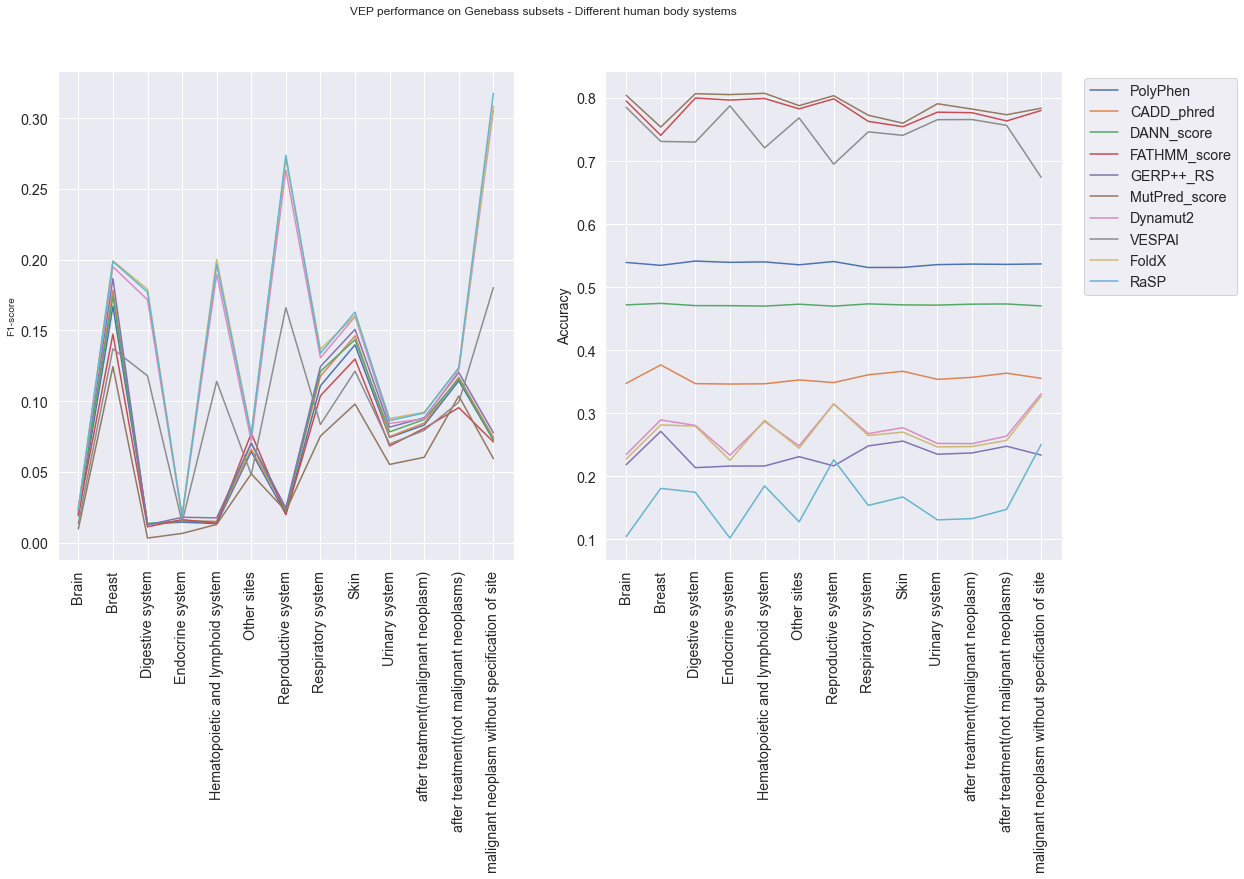

In [25]:
sns.set(font_scale=1.3)
# Create a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(18, 9))

# Plot the first lineplot on the first subplot
sns.lineplot(x='subset', y='F1-Score', hue='VEP Tool', data=f1_melted, ax=axes[0])
# Rotate x-axis labels on ax1
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
# Remove x-label
axes[0].set_xlabel(None)
axes[0].set_ylabel('F1-score')
axes[0].legend('', frameon=False)
# Plot the second lineplot on the second subplot
sns.lineplot(x='subset', y='Accuracy', hue='VEP Tool', data=acc_melted, ax=axes[1])
# Rotate x-axis labels on ax1
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
# Remove x-label
axes[1].set_xlabel(None)
axes[1].set_ylabel('Accuracy',fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
# Set the common y-axis label
fig.suptitle('VEP performance on Genebass subsets - Different human body systems')

# plt.savefig('/Users/joannahench/Documents/UCPH/MSc_Thesis/thesis_figures/gb_subsets_1.png')
# Show the plot
plt.show()

### subset, different functional annotations

In [611]:
anno_df = pd.read_csv('/Users/joannahench/Documents/UCPH/MSc_Thesis/GPCRdb_VEPs/processed_func_anno.csv')
anno_df = anno_df.rename(columns={'mutation_pos':'Protein_position'})

/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [590]:
# read in all gene names
gene_list_raw =pd.read_csv("230323_EST_ENSG_GENE_new.csv")
gene_list_raw.rename(columns={'gene':'SYMBOL'},inplace=True)
gene_list_raw

,index,ENST,ENSG,protein,SYMBOL,Uniprot
0,0,ENST00000646641,ENSG00000267534,s1pr2_human,S1PR2,O95136
1,121,ENST00000547270,ENSG00000257138,t2r38_human,TAS2R38,P59533
2,219,ENST00000390675,ENSG00000256436,t2r31_human,TAS2R31,P59538
3,344,ENST00000539585,ENSG00000256188,t2r30_human,TAS2R30,P59541
4,483,ENST00000538986,ENSG00000255837,t2r20_human,TAS2R20,P59543
...,...,...,...,...,...,...
395,64029,ENST00000510937,ENSG00000226306,npy6r_human,NPY6R,Q99463
396,64030,ENST00000641193,ENSG00000279301,o2t11_human,OR2T11,Q8NH01
397,64031,ENST00000641732,ENSG00000172146,or1a1_human,OR1A1,Q9P1Q5
398,64032,ENST00000328890,ENSG00000183024,or1g1_human,OR1G1,P47890


In [592]:
VEPwithGB_icd10 = pd.merge(VEPwithGB_icd10,gene_list_raw[['protein','SYMBOL']],on='SYMBOL')
# gb_with_dyna = pd.merge(gb_with_dyna,gene_list_raw[['protein','SYMBOL']],on='SYMBOL')
gb_with_vespa = pd.merge(gb_with_vespa,gene_list_raw[['protein','SYMBOL']],on='SYMBOL')


In [794]:
VEPwithGB_anno = VEPwithGB_icd10.merge(anno_df[['protein','Protein_position','func_anno']],on=['protein','Protein_position'])
Dynamut2withGB_anno = pd.merge(gb_with_dyna,anno_df[['protein','Protein_position','func_anno']],on=['protein','Protein_position'])
VESPAwithGB_anno = pd.merge(gb_with_vespa,anno_df[['protein','Protein_position','func_anno']],on=['protein','Protein_position'])
FoldXwithGB_anno = pd.merge(gb_with_fx,anno_df[['protein','Protein_position','func_anno']],on=['protein','Protein_position'])
RASPwithGB_anno = pd.merge(gb_with_rasp,anno_df[['protein','Protein_position','func_anno']],on=['protein','Protein_position'])

In [795]:
func_unknown = ['func_unknown']
LB_structure_human = ['LB_structure_human']
LB_fam = ['LB_fam']
Other_func = ['ActivationPathway','MicroSwitch','PTMsite','SodiumPocket']
Gprotein_interface = ['GProteinInteraction']


merge_class = {'func_unknown': func_unknown, 'LB_structure_human':LB_structure_human,'LB_fam':LB_fam,'Other_func':Other_func,'Gprotein_interface':Gprotein_interface}

# create a function to map classes to new_classes
def map_classes(x):
    for key, value in merge_class.items():
        if x in value:
            return key
    return 'other'

# add new column to dataframe
VEPwithGB_anno['functional_site'] = VEPwithGB_anno['func_anno'].apply(map_classes)
Dynamut2withGB_anno['functional_site'] = Dynamut2withGB_anno['func_anno'].apply(map_classes)
VESPAwithGB_anno['functional_site'] = VESPAwithGB_anno['func_anno'].apply(map_classes)
FoldXwithGB_anno['functional_site'] = FoldXwithGB_anno['func_anno'].apply(map_classes)
RASPwithGB_anno['functional_site'] = RASPwithGB_anno['func_anno'].apply(map_classes)


In [796]:
prot_list = np.unique(VEPwithGB_anno['protein'])
prot_list

array(['5ht1a_human', '5ht1b_human', '5ht1d_human', '5ht2a_human',
       '5ht2b_human', '5ht2c_human', '5ht4r_human', '5ht5a_human',
       '5ht6r_human', '5ht7r_human', 'aa1r_human', 'aa2ar_human',
       'aa2br_human', 'aa3r_human', 'acm1_human', 'acm3_human',
       'acm4_human', 'acm5_human', 'ada1a_human', 'ada1b_human',
       'ada1d_human', 'ada2a_human', 'ada2b_human', 'adrb1_human',
       'adrb2_human', 'adrb3_human', 'calrl_human', 'casr_human',
       'ccr1_human', 'ccr2_human', 'ccr3_human', 'ccr5_human',
       'ccr8_human', 'cnr2_human', 'crfr1_human', 'cxcr1_human',
       'cxcr2_human', 'cxcr3_human', 'cxcr4_human', 'drd1_human',
       'drd2_human', 'drd3_human', 'drd4_human', 'drd5_human',
       'ednrb_human', 'fshr_human', 'ghrhr_human', 'gipr_human',
       'glp1r_human', 'glr_human', 'grm1_human', 'grm2_human',
       'grm5_human', 'hrh1_human', 'hrh2_human', 'hrh3_human',
       'hrh4_human', 'lshr_human', 'mc4r_human', 'p2ry2_human',
       'p2y12_human', 'pth

In [627]:
def vep_sub_perf(df,subset):
    all_gpcr_res = pd.DataFrame()
    if subset=='ligand':
        for prot in prot_list:
            ligands = np.unique(df[df['protein']==prot]['ligand type'].tolist())
            for i in range(len(ligands)):
                temp = df[(df['protein'] == prot) & (df['ligand type'] == ligands[i])]
                temp_out = get_performance(temp,'max',general=False)
                temp_out['ligand type']=ligands[i]
                all_gpcr_res = pd.concat([all_gpcr_res, temp_out], ignore_index=True)
        return all_gpcr_res
    elif subset=='function':
        for prot in prot_list:
            print(prot)
            func = np.unique(df[df['protein']==prot]['functional_site'].tolist())
            for i in range(len(func)):
                print(func[i])
                temp = df[(df['protein'] == prot) & (df['functional_site'] == func[i])]
                temp_out = get_performance(temp,'max',general=False)
                temp_out['functional_site']=func[i]
                all_gpcr_res = pd.concat([all_gpcr_res, temp_out], ignore_index=True)
        return all_gpcr_res

def vep_sub_perf_other(df,type,subset):
    all_gpcr_res = pd.DataFrame()
    if subset=='ligand':
        for prot in prot_list:
            ligands = np.unique(df[df['protein']==prot]['ligand type'].tolist())
            for i in range(len(ligands)):
                temp = df[(df['protein'] == prot) & (df['ligand type'] == ligands[i])]
                temp_out = get_performance_other(temp,type,'max',general=False)
                temp_out['ligand type']=ligands[i]
                all_gpcr_res = pd.concat([all_gpcr_res, temp_out], ignore_index=True)
        return all_gpcr_res
    elif subset=='function':
        for prot in prot_list:
            print(prot)
            func = np.unique(df[df['protein']==prot]['functional_site'].tolist())
            for i in range(len(func)):
                print(func[i])
                temp = df[(df['protein'] == prot) & (df['functional_site'] == func[i])]
                temp_out = get_performance_other(temp,type,'max',general=False)
                temp_out['functional_site']=func[i]
                all_gpcr_res = pd.concat([all_gpcr_res, temp_out], ignore_index=True)
        return all_gpcr_res


In [636]:
d1 = VEPwithGB_anno[VEPwithGB_anno['protein']=='5ht2c_human']

In [ ]:
ensemble_with_anno_perf = vep_sub_perf(VEPwithGB_anno,'function')
dyna_with_anno_perf = vep_sub_perf_other(Dynamut2withGB_anno,'Dynamut2','function')
ves_with_anno_perf = vep_sub_perf_other(VESPAwithGB_anno,'VESPAl','function')
fdx_with_anno_perf = vep_sub_perf_other(FoldXwithGB_anno,'FoldX','function')
rasp_with_anno_perf = vep_sub_perf_other(RASPwithGB_anno,'RaSP','function')

In [888]:
sub_anno_perf_df = pd.concat([ensemble_with_anno_perf,dyna_with_anno_perf,ves_with_anno_perf,fdx_with_anno_perf,rasp_with_anno_perf]).reset_index()
sub_anno_perf_df = sub_anno_perf_df.drop(columns=['index'])
res3 = sub_anno_perf_df[sub_anno_perf_df['vep'].isin(VEP_list_sub+['Dynamut2','VESPAl','FoldX','RaSP'])]
# take average
res4 = pd.DataFrame(res3.groupby(by=["vep","functional_site"]).mean())



/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_55020/3489318051.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90,fontsize=14)
/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_55020/3489318051.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90,fontsize=14)


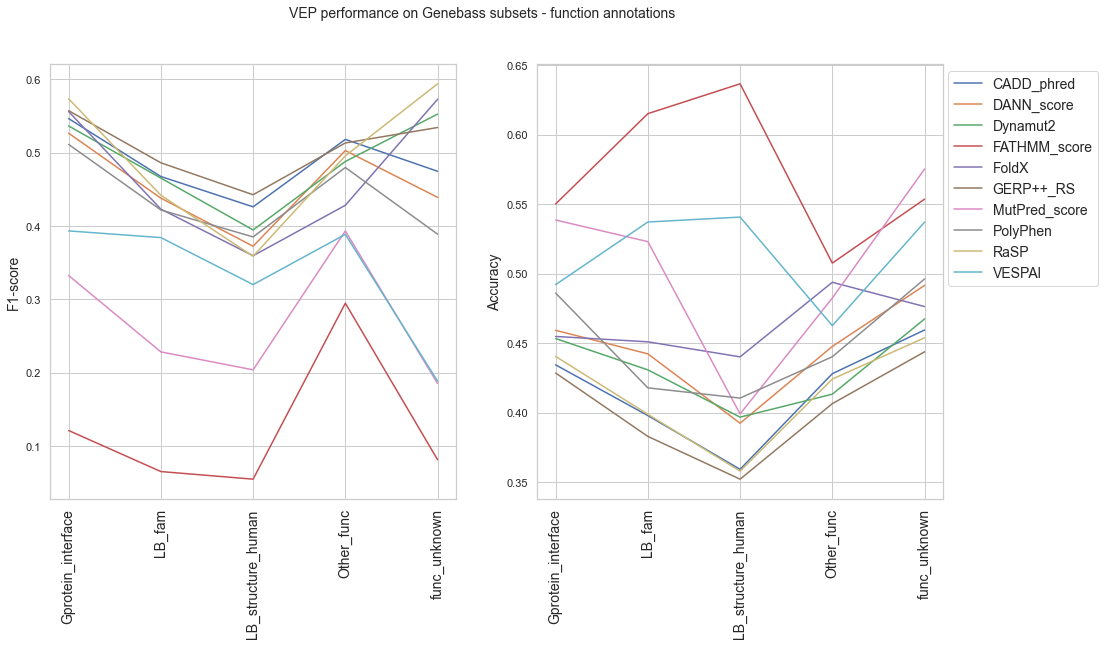

In [915]:
sns.set(style="whitegrid")
# Create a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

# Plot the first lineplot on the first subplot

sns.lineplot(data=res4, x='functional_site', y='f1-score', hue='vep',err_style="bars",ax=axes[0])
# Rotate x-axis labels on ax1
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90,fontsize=14)
# Remove x-label
axes[0].set_xlabel(None)
axes[0].set_ylabel('F1-score',fontsize=14)
axes[0].legend('', frameon=False)

# Plot the second lineplot on the second subplot
sns.lineplot(data=res4, x='functional_site', y='accuracy', hue='vep',err_style="bars",ax=axes[1])
# Rotate x-axis labels on ax1
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90,fontsize=14)
# Remove x-label
axes[1].set_xlabel(None)
axes[1].set_ylabel('Accuracy',fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1),fontsize=14)

# Set the common y-axis label
fig.suptitle('VEP performance on Genebass subsets - function annotations',fontsize=14)
plt.savefig('/Users/joannahench/Documents/UCPH/MSc_Thesis/thesis_figures/gb_subsets_2.png')
# Show the plot
plt.show()

In [ ]:
VEPwithGB_anno_1 = VEPwithGB_anno[VEPwithGB_anno['func_anno']=='func_unknown']
VEPwithGB_anno_1

In [ ]:
# beta for different func anno




#pvalue for different func anno




## diff thresholds

In [26]:
perf_dm_p_all = pd.DataFrame()
pval_list=[0.9,0.5,0.2,0.1,0.01,0.001,0.0001]
for i in range(len(pval_list)):
    perf_df_dm = get_performance(VEPwithGB_icd10,'max',beta=2,pval=pval_list[i],general=True)
    perf_df_dm['pval']=pval_list[i]
    perf_dyna = get_performance_other(gb_with_dyna,'Dynamut2','max',beta=2,pval=pval_list[i],general=True)
    perf_dyna['pval']=pval_list[i]
    perf_ves = get_performance_other(gb_with_vespa,'VESPAl','max',beta=2,pval=pval_list[i],general=True)
    perf_ves['pval']=pval_list[i]
    perf_fx = get_performance_other(gb_with_fx,'FoldX','max',beta=2,pval=pval_list[i],general=True)
    perf_fx['pval']=pval_list[i]
    perf_rasp = get_performance_other(gb_with_rasp,'RaSP','max',beta=2,pval=pval_list[i],general=True)
    perf_rasp['pval']=pval_list[i]    
    perf_dm_p_all = pd.concat([perf_dm_p_all,perf_df_dm,perf_dyna,perf_ves,perf_fx,perf_rasp],ignore_index=True)


perf_dm_p_all

/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_46245/183173339.py:28: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  ag_df = vep_gb_df.groupby(by=["SYMBOL","Protein_position","Amino_acids"]).max()[['vep_group','GB_group']]
/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_46245/183173339.py:28: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  ag_df = vep_gb_df.groupby(by=["SYMBOL","Protein_position","Amino_acids"]).max()[['vep_group','GB_group']]
/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_46245/183173339.py:28: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be 

,vep,accuracy,precision,f1-score,mcc,specificity,sensitivity,AUC,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive,pval
0,SIFT,0.467239,0.439381,0.472281,-0.060249,0.429333,0.510506,0.469919,3693/4712,3545/3541,8257,7234,7086,8405,0.9000
1,PolyPhen,0.479762,0.441597,0.436315,-0.046577,0.522345,0.431158,0.476752,3119/3944,4313/4115,8257,7234,8428,7063,0.9000
2,BayesDel_addAF_score,0.460198,0.386029,0.313828,-0.111157,0.631706,0.264381,0.448043,1912/3041,5216/5320,8257,7232,10536,4953,0.9000
3,BayesDel_noAF_score,0.480405,0.407483,0.308710,-0.075154,0.683541,0.248479,0.466010,1797/2613,5644/5435,8257,7232,11079,4410,0.9000
4,CADD_phred,0.460977,0.444927,0.519175,-0.060781,0.318881,0.623168,0.471025,4508/5624,2633/2726,8257,7234,5359,10132,0.9000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,MutPred_score,0.811205,0.000000,0.000000,-0.006007,0.811331,0.000000,0.405666,0/2431,10454/2,12885,2,10456,2431,0.0001
199,Dynamut2,0.459571,0.425140,0.548359,0.000930,0.228636,0.772154,0.500395,5080/6869,2036/1499,8905,6579,3535,11949,0.0001
200,VESPAl,0.531861,0.398438,0.258352,-0.028853,0.785316,0.191148,0.488232,1071/1617,5915/4532,7532,5603,10447,2688,0.0001
201,FoldX,0.470938,0.433364,0.561503,0.032432,0.229871,0.797234,0.513552,5245/6858,2047/1334,8905,6579,3381,12103,0.0001


In [931]:
perf_dm_beta_all = pd.DataFrame()
beta_list=[-1,1,3,5,7,9]
for i in range(len(beta_list)):
    perf_df_dm = get_performance(VEPwithGB_icd10,'max',beta_list[i],0.1,general=True)
    perf_df_dm['beta']=beta_list[i]
    perf_dyna = get_performance_other(gb_with_dyna,'Dynamut2','max',beta_list[i],0.1,general=True)
    perf_dyna['beta']=beta_list[i]
    perf_ves = get_performance_other(gb_with_vespa,'VESPAl','max',beta_list[i],0.1,general=True)
    perf_ves['beta']=beta_list[i]
    perf_fx = get_performance_other(gb_with_fx,'FoldX','max',beta_list[i],0.1,general=True)
    perf_fx['beta']=beta_list[i]
    perf_rasp = get_performance_other(gb_with_rasp,'RaSP','max',beta_list[i],0.1,general=True)
    perf_rasp['beta'] = beta_list[i]
    perf_dm_beta_all = pd.concat([perf_dm_beta_all,perf_df_dm,perf_dyna,perf_ves,perf_fx,perf_rasp],ignore_index=True)

perf_dm_beta_all

/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_55020/183173339.py:28: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  ag_df = vep_gb_df.groupby(by=["SYMBOL","Protein_position","Amino_acids"]).max()[['vep_group','GB_group']]
/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_55020/183173339.py:28: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  ag_df = vep_gb_df.groupby(by=["SYMBOL","Protein_position","Amino_acids"]).max()[['vep_group','GB_group']]
/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_55020/183173339.py:28: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be 

,vep,accuracy,precision,f1-score,mcc,specificity,sensitivity,AUC,#tp/#fp,#tn/#fn,#exp_negative,#exp_positive,#pred_negative,#pred_positive,beta
0,SIFT,0.447679,0.050803,0.090755,-0.062228,0.449261,0.424876,0.437068,427/7978,6508/578,14486,1005,7086,8405,-1
1,PolyPhen,0.525015,0.050262,0.088002,-0.054317,0.536932,0.353234,0.445083,355/6708,7778/650,14486,1005,8428,7063,-1
2,BayesDel_addAF_score,0.632772,0.027054,0.044997,-0.105039,0.667334,0.133599,0.400467,134/4819,9667/869,14486,1003,10536,4953,-1
3,BayesDel_noAF_score,0.670024,0.034240,0.055792,-0.078232,0.705992,0.150548,0.428270,151/4259,10227/852,14486,1003,11079,4410,-1
4,CADD_phred,0.349493,0.052310,0.095178,-0.070154,0.337153,0.527363,0.432258,530/9602,4884/475,14486,1005,5359,10132,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,MutPred_score,0.811283,0.000000,0.000000,-0.004248,0.811346,0.000000,0.405673,0/2431,10455/1,12886,1,10456,2431,9
170,Dynamut2,0.453952,0.416520,0.540714,-0.002553,0.227394,0.770433,0.498914,4977/6972,2052/1483,9024,6460,3535,11949,9
171,VESPAl,0.534374,0.388765,0.254692,-0.032202,0.784298,0.189380,0.486839,1045/1643,5974/4473,7617,5518,10447,2688,9
172,FoldX,0.467386,0.426175,0.555729,0.034420,0.230386,0.798452,0.514419,5158/6945,2079/1302,9024,6460,3381,12103,9


In [27]:
# import the names of VEPs
VEP_list_sub = [
# "SIFT",
"PolyPhen",
# "BayesDel_addAF_score",
# "BayesDel_noAF_score",
"CADD_phred",
# "ClinPred_score",
"DANN_score",
# "DEOGEN2_score",
"FATHMM_score",
# "integrated_fitCons_score",
# "LIST-S2_score",
# "LRT_score",
# "M-CAP_score",
# "MVP_score",
# "MetaLR_score",
# "MetaRNN_score",
# "MetaSVM_score",
# "MutationAssessor_score",
# "PROVEAN_score",
# "PrimateAI_score",
# "REVEL_score",
# "VEST4_score",
"GERP++_RS",
# "SiPhy_29way_logOdds",
"MutPred_score"
]


/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_46245/37843634.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(),fontsize=14)
/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/joannahench/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_46245/37843634.py:27: Us

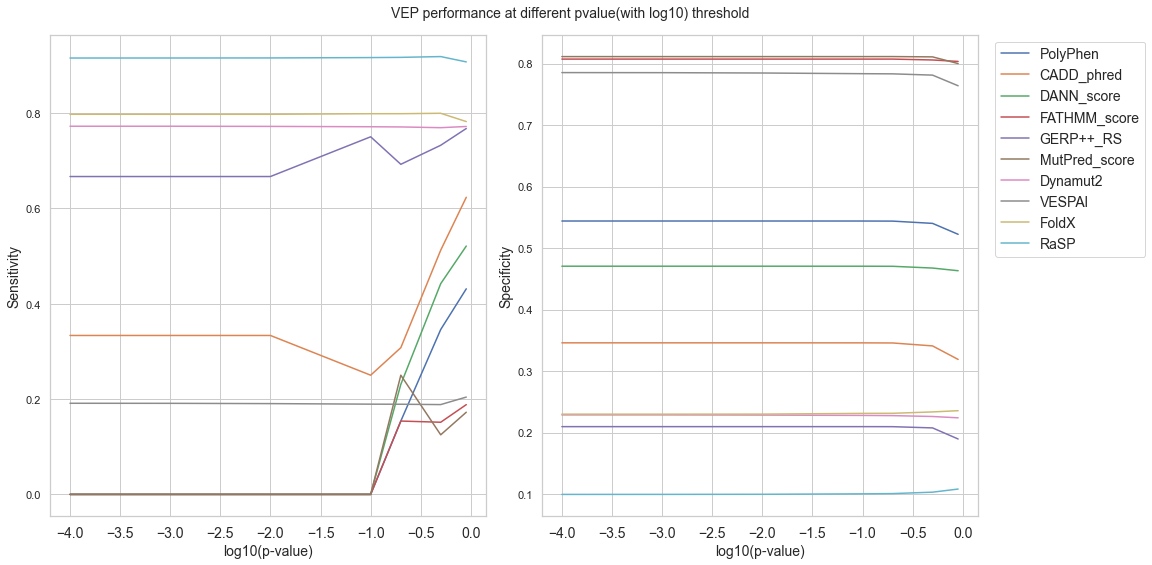

In [37]:
sns.set(style="whitegrid")
perf_dm_p_all['log_p'] = np.log10(perf_dm_p_all['pval'])
# Create a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

# Plot the first lineplot on the first subplot

sns.lineplot(data=perf_dm_p_all[perf_dm_p_all['vep'].isin(VEP_list_sub+['Dynamut2','VESPAl','FoldX','RaSP'])], x='log_p', y='sensitivity', hue='vep',err_style="bars",ax=axes[0])
# Rotate x-axis labels on ax1
# axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
# Remove x-label
# axes[0].set_xlabel(None)
axes[0].set_xticklabels(axes[0].get_xticklabels(),fontsize=14)
# axes[0].set_xlabel(None)
axes[0].set_ylabel('Sensitivity',fontsize=14)
axes[0].set_xlabel('log10(p-value)',fontsize=14)
axes[0].legend('', frameon=False)

# Plot the second lineplot on the second subplot
sns.lineplot(data=perf_dm_p_all[perf_dm_p_all['vep'].isin(VEP_list_sub+['Dynamut2','VESPAl','FoldX','RaSP'])], x='log_p', y='specificity', hue='vep',err_style="bars",ax=axes[1])
# axes[1].set_xlim(0,0.1)
# Rotate x-axis labels on ax1
# axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
# Remove x-label
# axes[1].set_xlabel(None)

axes[1].set_xticklabels(axes[1].get_xticklabels(),fontsize=14)
# axes[1].set_xlabel(None)
axes[1].set_ylabel('Specificity',fontsize=14)
axes[1].set_xlabel('log10(p-value)',fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1),fontsize=14)

# Set the common y-axis label
fig.suptitle('VEP performance at different pvalue(with log10) threshold',fontsize=14)
plt.tight_layout()


# plt.savefig('/Users/joannahench/Documents/UCPH/MSc_Thesis/thesis_figures/gb_thresh_p_pre_accu.png')
# Show the plot
plt.show()

/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_55020/4019279578.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(),fontsize=14)
/var/folders/d_/0pdh465d0yj2_tbpjd8dr11c0000gn/T/ipykernel_55020/4019279578.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(),fontsize=14)


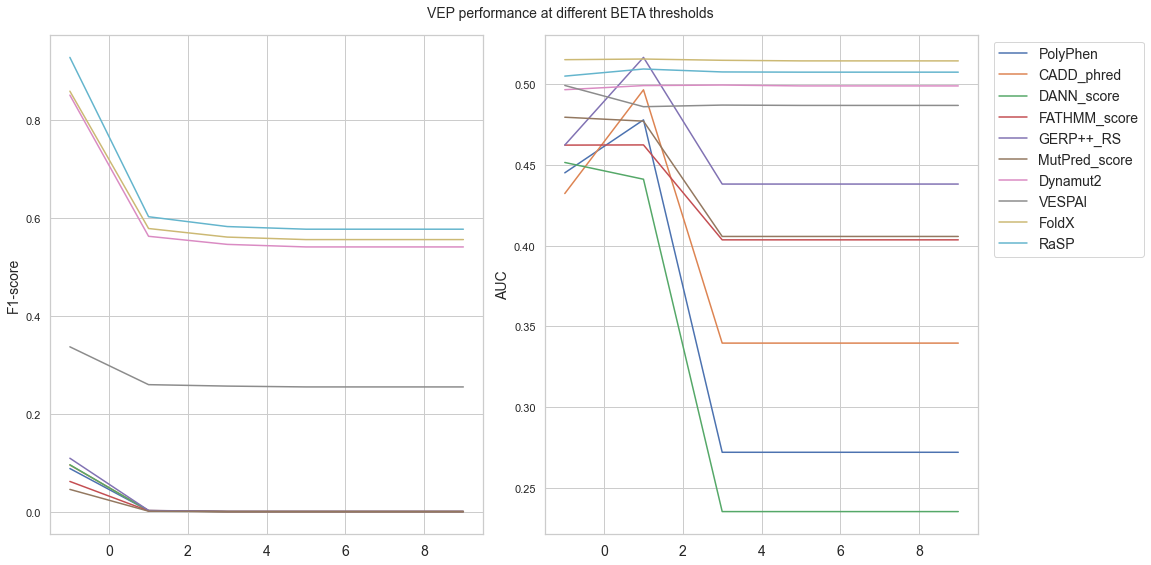

In [941]:
sns.set(style="whitegrid")
# Create a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

# Plot the first lineplot on the first subplot

sns.lineplot(data=perf_dm_beta_all[perf_dm_beta_all['vep'].isin(VEP_list_sub+['Dynamut2','VESPAl','FoldX','RaSP'])], x='beta', y='f1-score', hue='vep',err_style="bars",ax=axes[0])
# Rotate x-axis labels on ax1
axes[0].set_xticklabels(axes[0].get_xticklabels(),fontsize=14)
axes[0].set_xlabel(None)
axes[0].set_ylabel('F1-score',fontsize=14)
# Remove x-label

axes[0].legend('', frameon=False)

# Plot the second lineplot on the second subplot
sns.lineplot(data=perf_dm_beta_all[perf_dm_beta_all['vep'].isin(VEP_list_sub+['Dynamut2','VESPAl','FoldX','RaSP'])], x='beta', y='AUC', hue='vep',err_style="bars",ax=axes[1])
# axes[1].set_xlim(0,0.1)
# Rotate x-axis labels on ax1
axes[1].set_xticklabels(axes[1].get_xticklabels(),fontsize=14)
# Remove x-label
axes[1].set_xlabel(None)
axes[1].set_ylabel('AUC',fontsize=14)

plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1),fontsize=14)

# Set the common y-axis label
fig.suptitle('VEP performance at different BETA thresholds',fontsize=14)
plt.tight_layout()
# Show the plot
plt.savefig('/Users/joannahench/Documents/UCPH/MSc_Thesis/thesis_figures/gb_thresh_beta_f1_auc.png')
# Show the plot
plt.show()

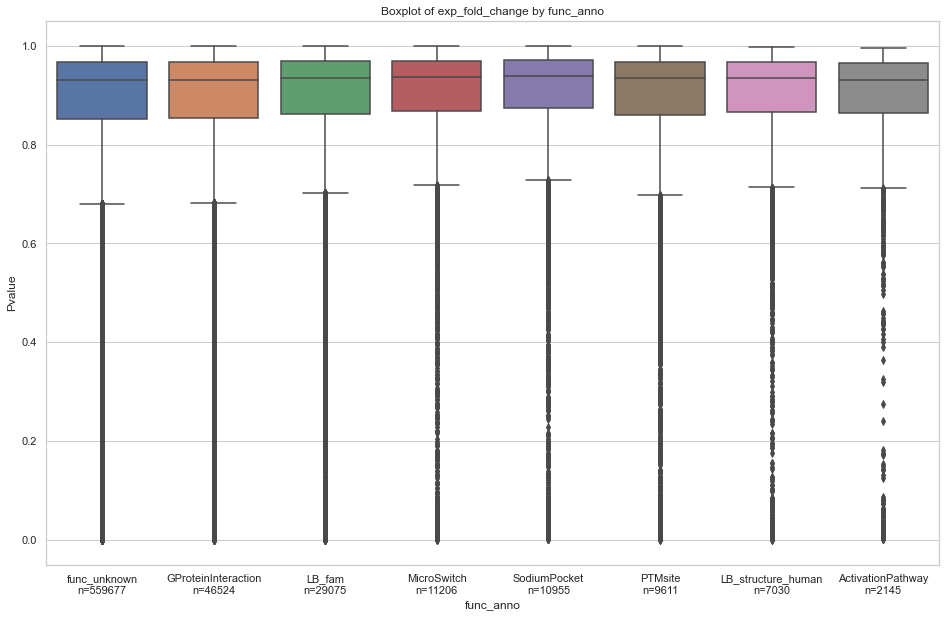

In [666]:




func_list = VEPwithGB_anno['func_anno'].value_counts().index.tolist()
func_num = VEPwithGB_anno['func_anno'].value_counts().values.tolist()

# create a new figure with a larger size
fig, ax = plt.subplots(figsize=(16, 10))

# create the boxplot
ax = sns.boxplot(data=VEPwithGB_anno, x="func_anno", y="Pvalue",order=func_list,ax=ax)
# ax.set_ylim(-3,0)

# set the tick labels as the combination of class name and sample size
xticklabels = [f"{class_name}\nn={func_num[i]}" for i, class_name in enumerate(func_list)]
plt.xticks(range(len(func_list)), xticklabels)


# add_stat_annotation(ax, data=VEPwithGB_anno, x="func_anno", y="log_abs_foldchange",
#                     box_pairs= pairs,
#                     test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)

# add a title to the plot
plt.title(f"Boxplot of exp_fold_change by func_anno")

# plt.savefig(f'boxplot_fc_by_function_for_each_ligand/{lig}.png')
# show the plot
plt.show()

## check the association between the number of variants and the vep score

In [361]:
extract_sub = ['Protein_position','SYMBOL','Amino_acids']+VEP_list
subset_icd10 = VEPwithGB_disease_potential[extract_sub]
subset_icd10

,Protein_position,SYMBOL,Amino_acids,SIFT,PolyPhen,BayesDel_addAF_score,BayesDel_noAF_score,CADD_phred,ClinPred_score,DANN_score,...,MetaRNN_score,MetaSVM_score,MutationAssessor_score,PROVEAN_score,PrimateAI_score,REVEL_score,VEST4_score,GERP++_RS,SiPhy_29way_logOdds,MutPred_score
12,327,DRD2,K/E,tolerated(0.27),benign(0.031),-0.260005,-0.140988,22.50,0.050145,0.997236,...,"0.006436944,0.006436944,0.006436944,0.00643694...",-0.8557,".,1.445,.,1.445,.","-0.57,-0.9,-0.85,-0.9,-0.93",0.639597,"0.212,0.212,0.212,0.212,0.212","0.487,0.487,0.499,0.486,0.499",5.97,16.4504,-
30,327,DRD2,K/E,tolerated(0.27),benign(0.031),-0.260005,-0.140988,22.50,0.050145,0.997236,...,"0.006436944,0.006436944,0.006436944,0.00643694...",-0.8557,".,1.445,.,1.445,.","-0.57,-0.9,-0.85,-0.9,-0.93",0.639597,"0.212,0.212,0.212,0.212,0.212","0.487,0.487,0.499,0.486,0.499",5.97,16.4504,-
44,327,DRD2,K/E,tolerated(0.27),benign(0.031),-0.260005,-0.140988,22.50,0.050145,0.997236,...,"0.006436944,0.006436944,0.006436944,0.00643694...",-0.8557,".,1.445,.,1.445,.","-0.57,-0.9,-0.85,-0.9,-0.93",0.639597,"0.212,0.212,0.212,0.212,0.212","0.487,0.487,0.499,0.486,0.499",5.97,16.4504,-
63,311,DRD2,S/C,deleterious(0.05),possibly_damaging(0.908),-0.393485,-0.293969,25.60,0.018995,0.992109,...,"0.0033855736,0.0033855736,0.0033855736,0.00338...",-0.4235,".,2.505,.,2.505,.","-0.41,-0.6,-0.49,-0.6,-0.61",0.526918,"0.230,0.230,0.230,0.230,0.230","0.32,0.244,0.263,0.244,0.183",5.73,19.9025,-
78,311,DRD2,S/C,deleterious(0.05),possibly_damaging(0.908),-0.393485,-0.293969,25.60,0.018995,0.992109,...,"0.0033855736,0.0033855736,0.0033855736,0.00338...",-0.4235,".,2.505,.,2.505,.","-0.41,-0.6,-0.49,-0.6,-0.61",0.526918,"0.230,0.230,0.230,0.230,0.230","0.32,0.244,0.263,0.244,0.183",5.73,19.9025,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654305,436,HTR2C,M/L,tolerated(0.1),benign(0.043),-0.152409,-0.456702,22.80,0.15596546318748,0.69975131897801768,...,"0.15887308,0.15887308",-1.1033,".,.","0.2,0.2",0.524445772171,"0.148,0.148","0.414,0.367",0.998,4.0071,0.254
654344,436,HTR2C,M/L,tolerated(0.1),benign(0.043),-0.152409,-0.456702,22.80,0.15596546318748,0.69975131897801768,...,"0.15887308,0.15887308",-1.1033,".,.","0.2,0.2",0.524445772171,"0.148,0.148","0.414,0.367",0.998,4.0071,0.254
654647,450,HTR2C,V/A,tolerated(0.27),benign(0.052),-0.175516,-0.438056,19.45,0.249420374631882,0.98381923381520309,...,"0.1508547,0.1508547",-0.9876,".,.","0.35,0.35",0.466780900955,"0.161,0.161","0.254,0.257",5.05,11.6062,-
654688,454,HTR2C,R/K,tolerated(0.67),benign(0.048),-0.281812,-0.590743,21.90,0.0695603415877406,0.85928267266573488,...,"0.08362916,0.08362916",-1.0218,".,.","0.24,0.24",0.508506894112,"0.076,0.076","0.182,0.143",4.11,9.0644,-


In [362]:
variant_stat = subset_icd10.groupby(['SYMBOL', 'Protein_position','Amino_acids']).size().reset_index(name='disease count')


for i in range(len(VEP_list)):  
    vep = VEP_list[i]
    print('processing VEP: ',vep)

    temp1 = subset_icd10[subset_icd10[vep]!='-'][['SYMBOL', 'Protein_position','Amino_acids',vep]].reset_index(drop=True)
    p1 = re.compile(r'[(](.*?)[)]', re.S)
    if vep == 'SIFT' or vep == 'PolyPhen':
        temp1[vep] = temp1[vep].apply(lambda x: float(re.findall(p1,x)[0])) 
    elif vep == 'DEOGEN2_score' or vep == 'FATHMM_score' or vep == 'LIST-S2_score' or vep == 'MetaRNN_score' or vep == 'MVP_score' or vep == 'MutationAssessor_score' or vep == 'PROVEAN_score' or vep == 'REVEL_score' or vep == 'VEST4_score':
        temp2 = temp1[vep].apply(lambda x: list(set(str(x).split(',')) - set(['.'])))
        temp2 = temp2.apply(lambda x: float(x[0]) if len(x) > 0 else None)
        temp1[vep] = temp2
        temp1 = temp1.dropna(subset=[vep]).reset_index(drop=True)
    temp1[vep] = temp1[vep].astype(float)
    # Group the dataframe by variant and calculate the VEP score count and average VEP score
    variant_scores = temp1.groupby(['SYMBOL', 'Protein_position', 'Amino_acids']).agg({vep: ['mean']}).reset_index()
    variant_scores.columns = variant_scores.columns.droplevel()

    # Rename the columns
    variant_scores.columns = ['SYMBOL', 'Protein_position', 'Amino_acids', vep]
    variant_stat = variant_stat.merge(variant_scores,on=['SYMBOL','Protein_position','Amino_acids'],how='outer')
    variant_stat

processing VEP:  SIFT
processing VEP:  PolyPhen
processing VEP:  BayesDel_addAF_score
processing VEP:  BayesDel_noAF_score
processing VEP:  CADD_phred
processing VEP:  ClinPred_score
processing VEP:  DANN_score
processing VEP:  DEOGEN2_score
processing VEP:  FATHMM_score
processing VEP:  integrated_fitCons_score
processing VEP:  LIST-S2_score
processing VEP:  LRT_score
processing VEP:  M-CAP_score
processing VEP:  MVP_score
processing VEP:  MetaLR_score
processing VEP:  MetaRNN_score
processing VEP:  MetaSVM_score
processing VEP:  MutationAssessor_score
processing VEP:  PROVEAN_score
processing VEP:  PrimateAI_score
processing VEP:  REVEL_score
processing VEP:  VEST4_score
processing VEP:  GERP++_RS
processing VEP:  SiPhy_29way_logOdds
processing VEP:  MutPred_score


In [363]:
variant_stat

,SYMBOL,Protein_position,Amino_acids,disease count,SIFT,PolyPhen,BayesDel_addAF_score,BayesDel_noAF_score,CADD_phred,ClinPred_score,...,MetaRNN_score,MetaSVM_score,MutationAssessor_score,PROVEAN_score,PrimateAI_score,REVEL_score,VEST4_score,GERP++_RS,SiPhy_29way_logOdds,MutPred_score
0,ADORA1,5,I/V,5,0.29,0.000,-0.255556,-0.604865,15.540,0.028809,...,0.067486,-1.0138,0.060,-0.16,0.409752,0.024,0.076,-0.585,9.2801,0.165
1,ADORA1,11,A/S,2,0.42,0.025,-0.095228,-0.374565,22.400,0.402853,...,0.280421,-0.8900,1.320,-0.85,0.621947,0.073,0.101,5.060,18.4302,NaN
2,ADORA1,28,V/M,1,0.01,0.346,-0.035792,-0.289189,24.300,0.944427,...,0.451129,-0.7827,2.315,-2.18,0.700289,0.160,0.433,5.200,6.7860,0.528
3,ADORA1,38,Q/K,2,0.39,0.010,-0.179289,-0.495312,20.700,0.658519,...,0.210616,-1.0905,0.070,-0.17,0.603796,0.081,0.096,5.200,18.7352,0.508
4,ADORA1,39,A/V,4,0.01,0.294,-0.170210,-0.186079,24.400,0.236914,...,0.185704,-0.0461,2.250,-1.94,0.641705,0.327,0.401,5.200,18.7352,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5875,VIPR2,424,G/S,1,0.18,0.009,-0.202862,-0.529173,11.020,0.376041,...,0.037084,-1.0472,1.335,0.89,0.479598,0.031,0.179,2.980,6.1668,0.194
5876,VIPR2,425,S/F,4,0.00,0.283,-0.016961,-0.262140,23.900,0.987344,...,0.429996,-0.8453,2.470,-3.16,0.625055,0.208,0.551,5.010,15.8185,0.401
5877,VIPR2,426,R/L,2,0.00,0.570,-0.264226,-0.293375,23.100,0.460053,...,0.144652,-0.5466,2.750,-3.81,0.571463,0.263,0.371,4.130,11.1992,NaN
5878,VIPR2,428,Q/R,1,0.04,0.007,-0.292451,-0.657862,7.957,0.089580,...,0.084695,-1.0202,1.155,-1.68,0.469505,0.113,0.085,-8.630,9.7578,0.274


In [ ]:
sns.distplot(variant_stat['disease count'])

In [365]:
variant_stat['variant'] = variant_stat['SYMBOL'].astype(str)+'_'+variant_stat['Protein_position'].astype(str)+'_'+variant_stat['Amino_acids'].astype(str)
# Linearly scale the 'disease count' column to range [0, 1]
variant_stat['count_scaled'] = variant_stat['disease count'].apply(lambda x: (x - variant_stat['disease count'].min()) / (variant_stat['disease count'].max() - variant_stat['disease count'].min()))
variant_stat


,SYMBOL,Protein_position,Amino_acids,disease count,SIFT,PolyPhen,BayesDel_addAF_score,BayesDel_noAF_score,CADD_phred,ClinPred_score,...,MutationAssessor_score,PROVEAN_score,PrimateAI_score,REVEL_score,VEST4_score,GERP++_RS,SiPhy_29way_logOdds,MutPred_score,variant,count_scaled
0,ADORA1,5,I/V,5,0.29,0.000,-0.255556,-0.604865,15.540,0.028809,...,0.060,-0.16,0.409752,0.024,0.076,-0.585,9.2801,0.165,ADORA1_5_I/V,0.444444
1,ADORA1,11,A/S,2,0.42,0.025,-0.095228,-0.374565,22.400,0.402853,...,1.320,-0.85,0.621947,0.073,0.101,5.060,18.4302,NaN,ADORA1_11_A/S,0.111111
2,ADORA1,28,V/M,1,0.01,0.346,-0.035792,-0.289189,24.300,0.944427,...,2.315,-2.18,0.700289,0.160,0.433,5.200,6.7860,0.528,ADORA1_28_V/M,0.000000
3,ADORA1,38,Q/K,2,0.39,0.010,-0.179289,-0.495312,20.700,0.658519,...,0.070,-0.17,0.603796,0.081,0.096,5.200,18.7352,0.508,ADORA1_38_Q/K,0.111111
4,ADORA1,39,A/V,4,0.01,0.294,-0.170210,-0.186079,24.400,0.236914,...,2.250,-1.94,0.641705,0.327,0.401,5.200,18.7352,NaN,ADORA1_39_A/V,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5875,VIPR2,424,G/S,1,0.18,0.009,-0.202862,-0.529173,11.020,0.376041,...,1.335,0.89,0.479598,0.031,0.179,2.980,6.1668,0.194,VIPR2_424_G/S,0.000000
5876,VIPR2,425,S/F,4,0.00,0.283,-0.016961,-0.262140,23.900,0.987344,...,2.470,-3.16,0.625055,0.208,0.551,5.010,15.8185,0.401,VIPR2_425_S/F,0.333333
5877,VIPR2,426,R/L,2,0.00,0.570,-0.264226,-0.293375,23.100,0.460053,...,2.750,-3.81,0.571463,0.263,0.371,4.130,11.1992,NaN,VIPR2_426_R/L,0.111111
5878,VIPR2,428,Q/R,1,0.04,0.007,-0.292451,-0.657862,7.957,0.089580,...,1.155,-1.68,0.469505,0.113,0.085,-8.630,9.7578,0.274,VIPR2_428_Q/R,0.000000


In [366]:
# Sort the DataFrame by the 'count_scaled' column in descending order
variant_stat_sorted = variant_stat.sort_values(by='count_scaled', ascending=False)

# Select the top 20% of rows
top_10_percent = variant_stat_sorted.head(n=int(len(variant_stat_sorted) * 0.01))

# Print the top 20% of rows
print(top_10_percent)

       SYMBOL  Protein_position Amino_acids  disease count  SIFT  PolyPhen  \
4446     HTR4               214         R/H             10  0.01     0.977   
2474     DRD4               272         G/V              9  0.20     0.000   
5389   TAS1R3                98         D/E              9  0.18     0.228   
4487    HTR5A                46         L/S              9  0.00     0.898   
319    ADRA1A               347         C/Y              9  0.12     0.000   
221    ADORA3               197         Y/H              9  0.00     1.000   
22     ADORA1               168         K/T              9  0.91     0.000   
121   ADORA2A               393         V/A              9  0.73     0.000   
5336     SCTR               299         R/H              9  0.00     0.996   
101   ADORA2A               304         R/H              9  0.28     0.005   
2018    CXCR2               153         R/H              8  0.17     0.115   
1408     CCR5               225         R/Q              8  0.03

In [ ]:
for i in range(len(VEP_list)):
    vep = VEP_list[i]
    # Group the DataFrame by the 'variant' column and calculate the mean for each group
    grouped_df = top_10_percent.groupby('variant').mean()[['count_scaled',vep]]
    grouped_df[vep] = grouped_df[vep].apply(lambda x: (x - grouped_df[vep].min()) / (grouped_df[vep].max() - grouped_df[vep].min()))


    sorted_df = grouped_df.sort_values(by='count_scaled', ascending=False)

    # Create a bar plot
    sorted_df.plot(kind='bar', rot=0, figsize=(55, 25))

    # plt.savefig(f'diseasenumber_vepscore/{vep}.png')
    plt.show()
    

In [49]:
vep = 'integrated_fitCons_score'
temp1 = subset_icd10[subset_icd10[vep]!='-'][['SYMBOL', 'Protein_position','Amino_acids',vep]].reset_index(drop=True)
p1 = re.compile(r'[(](.*?)[)]', re.S)
if vep == 'SIFT' or vep == 'PolyPhen':
    temp1[vep] = temp1[vep].apply(lambda x: float(re.findall(p1,x)[0])) 

elif vep == 'DEOGEN2_score' or vep == 'FATHMM_score' or vep == 'LIST-S2_score' or vep == 'MetaRNN_score' or vep == 'MVP_score' or vep == 'MutationAssessor_score' or vep == 'PROVEAN_score' or vep == 'REVEL_score' or vep == 'VEST4_score':
    temp2 = temp1[vep].apply(lambda x: list(set(str(x).split(',')) - set(['.'])))
    temp2 = temp2.apply(lambda x: float(x[0]) if len(x) > 0 else None)
    temp1[vep] = temp2
    temp1 = temp1.dropna(subset=[vep]).reset_index(drop=True)
temp1[vep] = temp1[vep].astype(float)
# Group the dataframe by variant and calculate the VEP score count and average VEP score
variant_scores = temp1.groupby(['SYMBOL', 'Protein_position', 'Amino_acids']).agg({vep: ['mean']}).reset_index()
variant_scores.columns = variant_scores.columns.droplevel()
# Rename the columns
variant_scores.columns = ['SYMBOL', 'Protein_position', 'Amino_acids',vep]
variant_counts = variant_counts.merge(variant_scores,on=['SYMBOL','Protein_position','Amino_acids'],how='outer')
variant_counts

,SYMBOL,Protein_position,Amino_acids,integrated_fitCons_score
0,ADORA1,5,I/V,0.657570
1,ADORA1,11,A/S,0.657570
2,ADORA1,14,G/S,0.676563
3,ADORA1,16,E/G,0.676563
4,ADORA1,25,P/A,0.676563
...,...,...,...,...
15307,VIPR2,431,L/Q,0.685219
15308,VIPR2,434,E/D,0.685219
15309,VIPR2,435,T/I,0.652421
15310,VIPR2,435,T/N,0.652421
